# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Знакомство с данными

Импортируем pandas и загрузим данные в датафрейм

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import math

pd.set_option('display.max_columns', 50) 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Посмотрим общую информацию о датафрейме с помощью метода `info()`

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице 23699 строк, 22 столбца.
Посмотрим на первые 5 записей

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Построим гистограмму для числовых столбцов датафрейма с помощью метода `hist()`

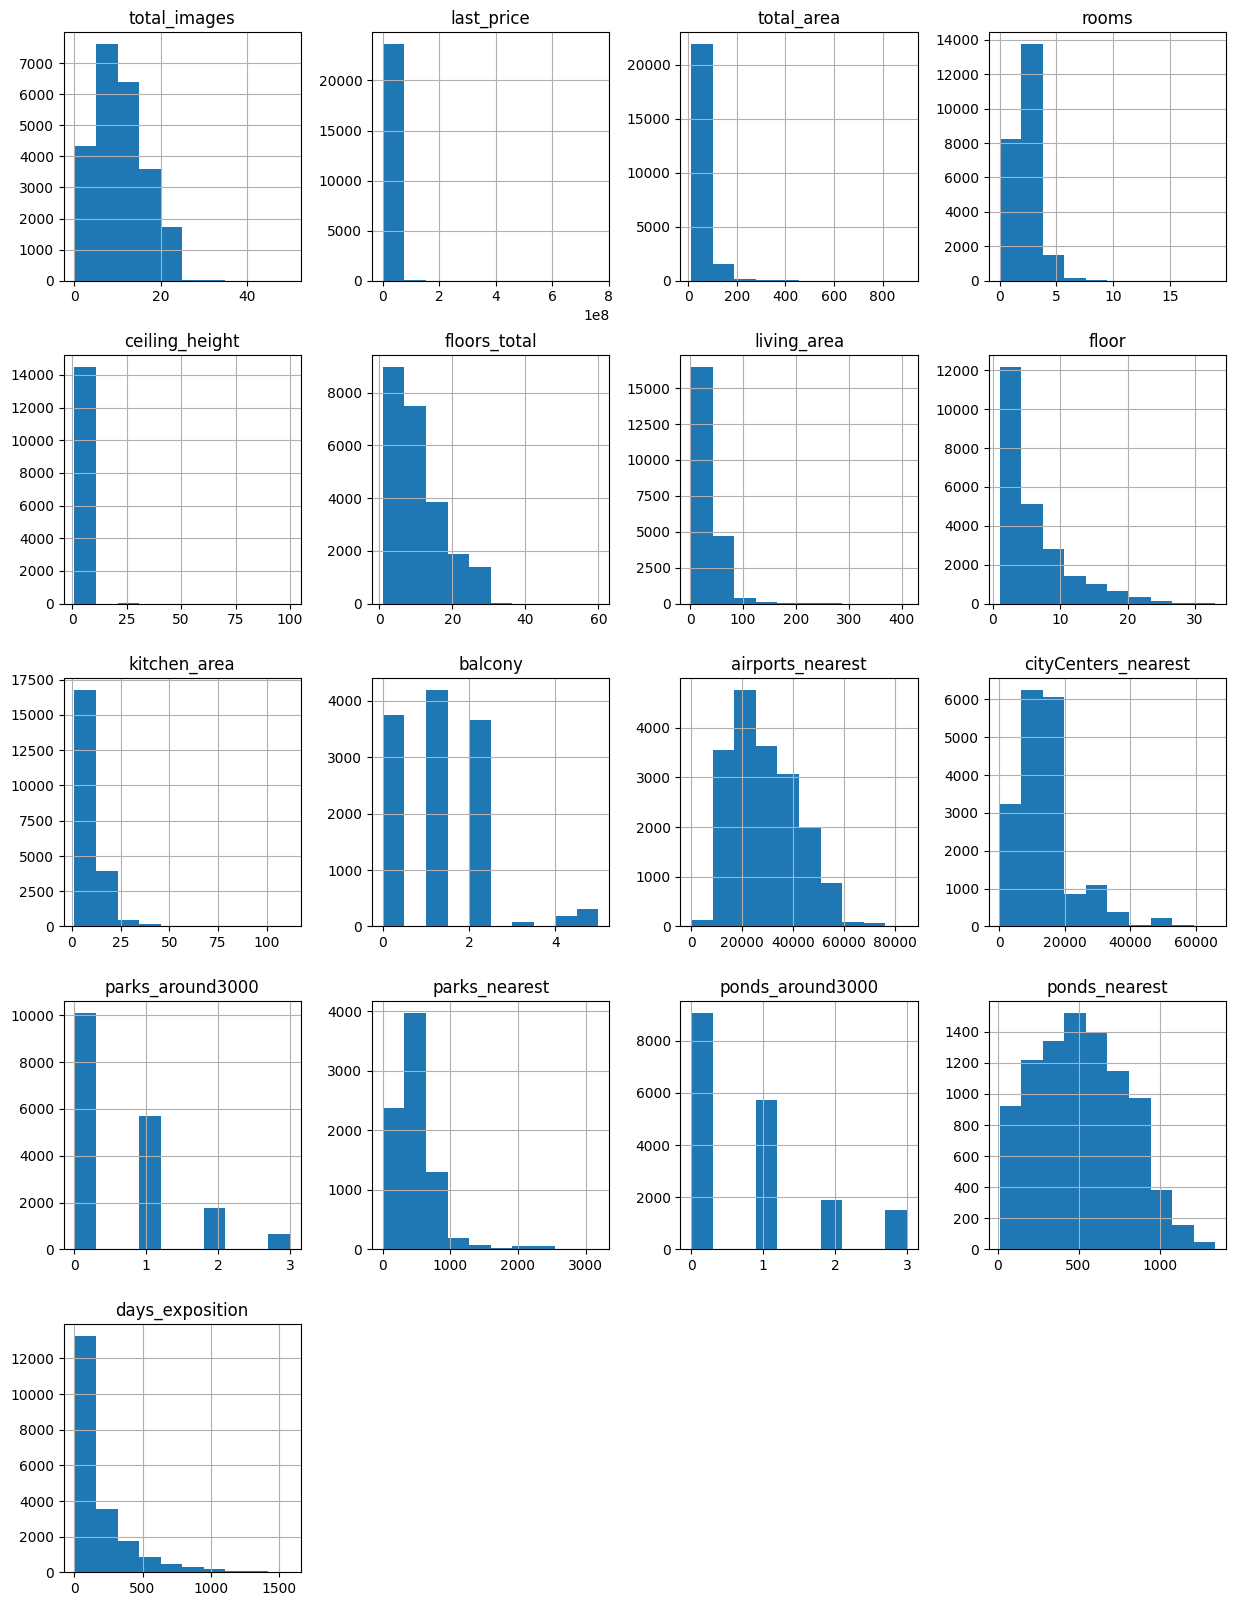

In [5]:
data.hist(figsize=(15,20))
None

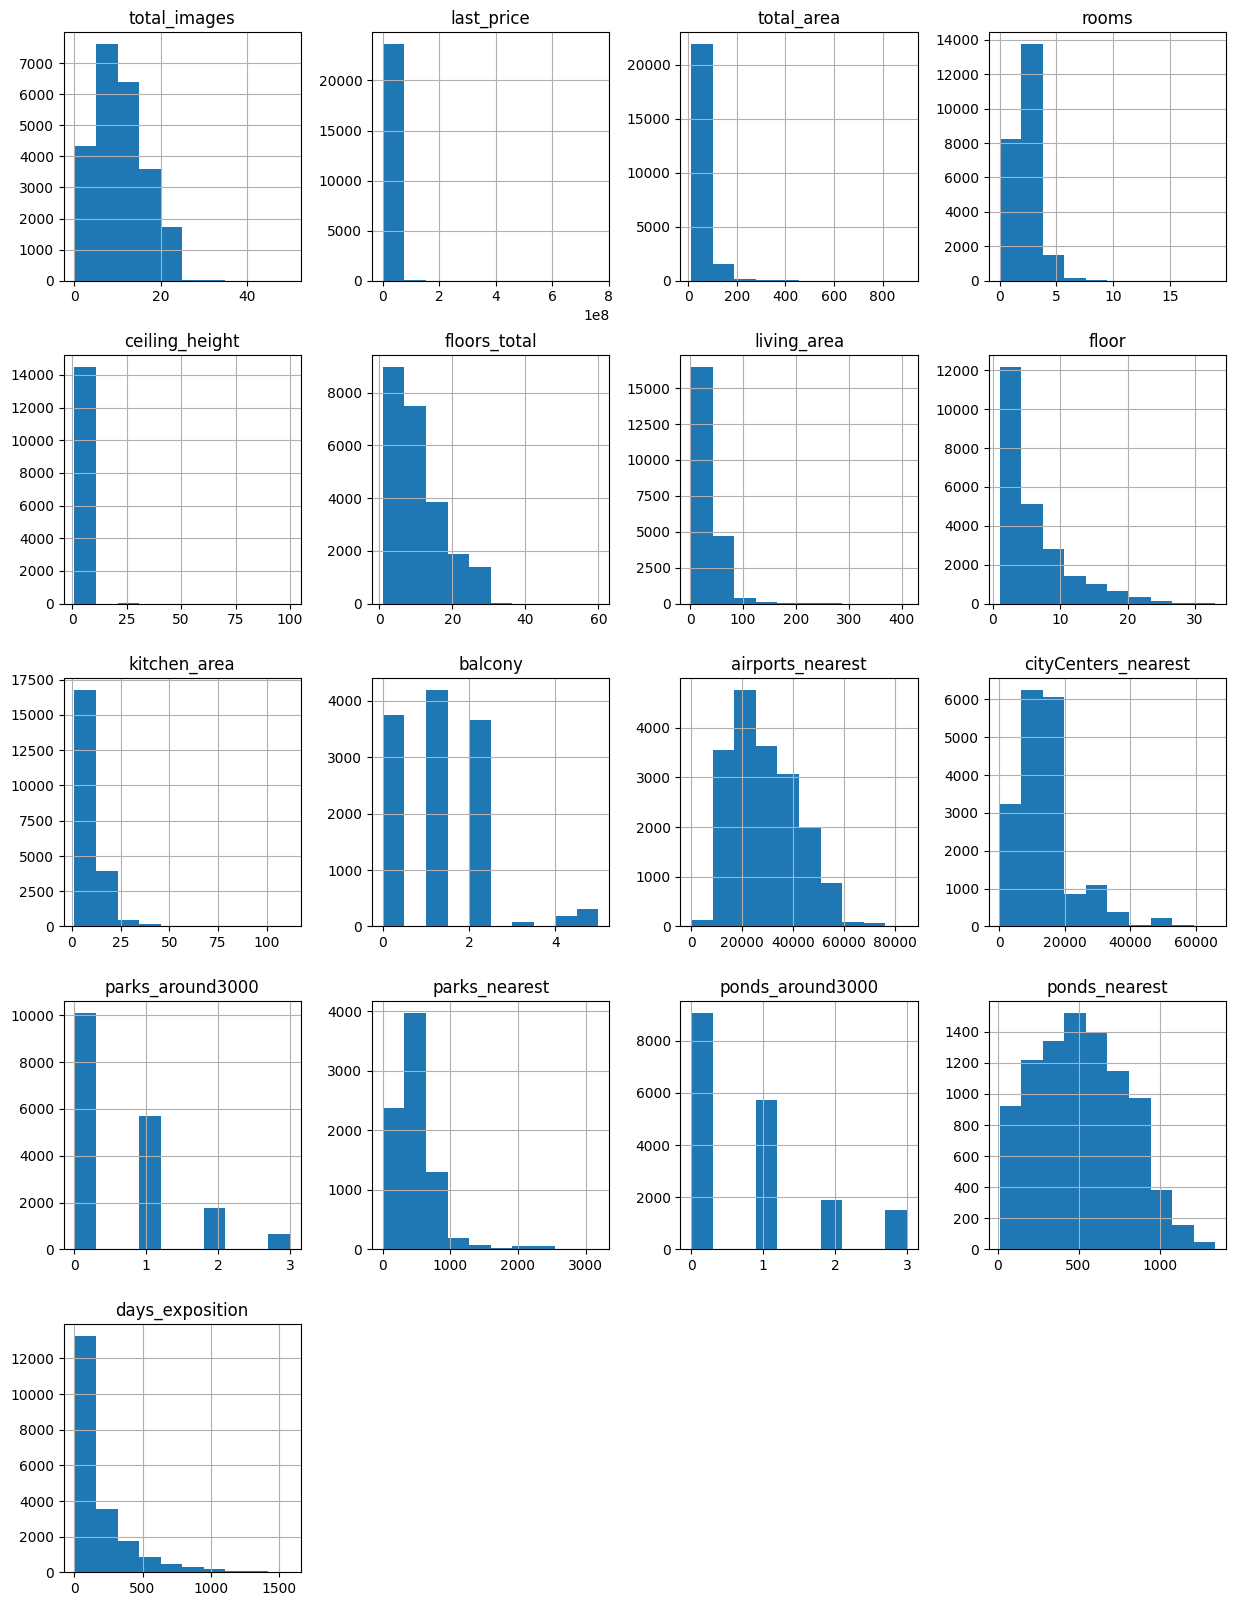

In [6]:
data.hist(figsize=(15, 20))
None

Мы видим, что на текущем этапе многие гистограммы неинформативны, так как в данных присутствуют выбросы и аномалии, искажающие их. 

## Предобработка данных

### Обработка пропусков 

Изучим, в каких столбцах имеются пропущенные значения. Применим методы `isna()` и `sum()`

In [7]:
pd.DataFrame({
    'missing_values_number': data.isna().sum(), 
    'missing_values_percentage': (data.isna().sum() * 100 / data.shape[0])
    .apply(lambda x: "{:.2f}%".format(x))
}).sort_values(by='missing_values_number', ascending=False)

,missing_values_number,missing_values_percentage
is_apartment,20924,88.29%
parks_nearest,15620,65.91%
ponds_nearest,14589,61.56%
balcony,11519,48.61%
ceiling_height,9195,38.80%
airports_nearest,5542,23.38%
cityCenters_nearest,5519,23.29%
ponds_around3000,5518,23.28%
parks_around3000,5518,23.28%
days_exposition,3181,13.42%


Больше всего пропущенных значений лежит в столбце `is_apartment`. Это булевая колонка, хранящая информацию о том, является ли недвижимость апартаментами. <br>
Также пропущенные значения имеются в колонках `parks_nearest` и `ponds_nearest`. Это картографические данные, обозначающие расстояние до ближайшего парка и водоема. <br>
Столбцы `balcony` - количество балконов и `ceiling_height` - высота потолков, также имеют большое количество пропусков. <br>
По примерно 5500 пропусков имеют картографические колонки `airports_nearest`,`cityCenters_nearest`,`ponds_around3000`,`parks_around3000`.  <br>
3181 пропуск находится в столбце `days_exposition` - сколько дней "провисело" объявление  <br>
2278 и 1903 пропусков находится в колонках `kitchen_area` и `living_area` - площадь кухни и общая жилая соответственно  <br>
Небольшое количество пропусков также имеют столбцы `floors_total` - количество этажей и `locality_name` - название населенного пункта.

Обработаем эти пропуски.

#### Пропуски в `is_apartment`

Для того, чтобы понять, что можно сделать с пропусками в колонке `is_apartment` посмотрим, какие значения и в каком количестве в ней находятся

In [8]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [9]:
data['is_apartment'].value_counts()

is_apartment
False    2725
True       50
Name: count, dtype: int64

Колонка хранит 50 значений True, 2725 False. Пропущено 88,3% значений. <br>
Предположим, что незаполненные значения - это False, то есть отсутсвие апартаментов. Но сначала посмотрим, как распределены апартаменты и не-апартаменты на Яндекс Недвижимости на текущий момент (июнь 2023). <br> 
На сайте Яндекс Недвижимости в Санкт-Петегрбурге и ЛО представлено 3609 апартаментов и 77437 не-апартаментов, то есть в процентном соотношении 4.45% и 95.5% соответственно. В имеющихся у нас данных (без пропущенных значений) апартаменты составляют 1.8%, не-апартаменты 98.2%.<br>
Если мы заполним все пропуски значением False, то доля апартаментов упадет до 0.21%. <br><br>

__Возможные причины пропусков__ <br>
Скорее всего, на момент сбора статистики на сайте Яндекс Недвижимости указание поля "апараменты" было необязательным. Люди, размещающие объявления либо не знали, что указывать в этом поле, либо осознанно не стали указывать, что их недвижимость является апартаментами, так как данный тип имеет свои недостатки  (отсутствие возможности оформить постоянную регистрацию, более высокая плата за коммунальные платежи, невозможность получить налоговый вычет) и обычно дешевле квартир примерно на 20%

Предположим, что пользователь, заполняющий данные, не указал тип "апартаменты", так как недвижимость ими не является. Заполним пропуски значением False. 

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Проверим, что пропусков не осталось

In [11]:
data.query('is_apartment.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


#### Пропуски в `parks_nearest`, `ponds_nearest`, `airports_nearest`, `cityCenters_nearest`, `ponds_around3000`, `parks_around3000`

Мы знаем, что это картографические данные, полученные алгоритмически. К сожалению, у нас нет информации о том, как эти данные были заполнены. <br><br>
__Возможные причины пропусков__ <br>
Причиной пропусков в этих данных может быть ошибка в алгоритме, написанном разработчиком. А может алгоритм просто не считает расстояния, превышающие определенное значение. Также причиной может быть отсутствие адреса в объявлении, т.е. создатель объявления мог его просто не указать. Во всяком случае, придется создать баг-репорт и обратиться к разработчикам с вопросом, почему для значительного количества объявлений отсутсвует информация по расстоянию

#### Пропуски в `balcony`

Изучим данные с пропусками в `balcony`

In [12]:
data.query('balcony.isna()').sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1712,4,2850000.0,32.0,2017-11-14T00:00:00,1,NaN,9.0,18.0,2,False,False,False,6.0,NaN,Санкт-Петербург,49480.0,15305.0,1.0,808.0,1.0,774.0,131.0
17591,0,3100000.0,46.5,2017-11-09T00:00:00,1,NaN,25.0,28.0,10,False,False,False,9.7,NaN,посёлок Шушары,13931.0,19717.0,0.0,NaN,1.0,582.0,46.0
7136,0,48000000.0,108.0,2018-02-01T00:00:00,3,NaN,5.0,61.0,2,False,False,False,13.5,NaN,Санкт-Петербург,24632.0,3180.0,1.0,551.0,3.0,415.0,144.0
3374,18,3650000.0,41.5,2018-02-14T00:00:00,3,2.5,5.0,NaN,3,False,False,False,NaN,NaN,Санкт-Петербург,12842.0,11005.0,0.0,NaN,1.0,745.0,24.0
5878,15,3100000.0,67.0,2017-12-18T00:00:00,3,NaN,9.0,NaN,1,False,False,False,NaN,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,45.0
1452,8,2650000.0,34.5,2017-12-14T00:00:00,1,NaN,19.0,17.3,17,False,False,False,8.5,NaN,Санкт-Петербург,42681.0,21997.0,0.0,NaN,1.0,682.0,40.0
21506,9,3490000.0,35.0,2018-09-23T00:00:00,1,NaN,3.0,22.0,1,False,False,False,7.0,NaN,Санкт-Петербург,21613.0,3940.0,0.0,NaN,3.0,358.0,15.0
2153,0,4600000.0,44.0,2019-04-11T00:00:00,3,NaN,5.0,34.0,2,False,False,False,5.0,NaN,Санкт-Петербург,10143.0,11367.0,0.0,NaN,0.0,NaN,7.0
22435,15,2000000.0,44.0,2016-12-23T00:00:00,2,2.5,5.0,27.5,1,False,False,False,5.5,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,432.0
16827,11,3050000.0,30.8,2017-08-25T00:00:00,1,2.5,7.0,17.2,1,False,False,False,5.8,NaN,Санкт-Петербург,42180.0,14684.0,1.0,491.0,0.0,NaN,459.0


Посмотрим, как распределены данные, где указано количество балконов

In [13]:
data['balcony'].value_counts()

balcony
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: count, dtype: int64

__Возможные причины пропусков__ <br>
Скорее всего, при заполнении данных объявления, человек не заполнил поле "балкон", так как он отсутствует.<br><br>

Заполним пропуски в поле `balcony` значением 0.

In [14]:
data['balcony'] = data['balcony'].fillna(0)

Убедимся, что пропуски были заполнены

In [15]:
data['balcony'].isna().sum()

0

#### Пропуски в `ceiling_height`

Посмотрим на записи с пропусками в данных о высоте потолка

In [16]:
data.query('ceiling_height.isna()').sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2074,11,2300000.0,65.0,2017-09-24T00:00:00,3,NaN,3.0,50.0,3,False,False,False,9.0,0.0,посёлок городского типа Ульяновка,NaN,NaN,NaN,NaN,NaN,NaN,268.0
14026,2,5270000.0,89.0,2018-07-05T00:00:00,3,NaN,25.0,48.0,15,False,False,False,11.5,0.0,посёлок Шушары,12431.0,18188.0,0.0,NaN,0.0,NaN,124.0
21511,7,7203654.0,48.0,2017-03-21T00:00:00,1,NaN,19.0,17.0,16,False,False,False,13.0,0.0,Санкт-Петербург,19325.0,4670.0,0.0,NaN,1.0,436.0,218.0
3205,10,2080000.0,32.7,2018-02-01T00:00:00,1,NaN,9.0,17.0,8,False,False,False,7.0,1.0,посёлок Шушары,18399.0,29646.0,0.0,NaN,0.0,NaN,167.0
17840,6,4500000.0,37.0,2018-02-28T00:00:00,1,NaN,22.0,16.0,11,False,False,False,9.0,1.0,Санкт-Петербург,15339.0,13512.0,0.0,NaN,0.0,NaN,111.0
22653,8,3400000.0,36.0,2018-01-06T00:00:00,1,NaN,23.0,17.0,5,False,False,False,11.0,1.0,Санкт-Петербург,21978.0,17306.0,0.0,NaN,1.0,379.0,45.0
13650,0,2000000.0,56.0,2019-04-03T00:00:00,2,NaN,5.0,30.2,5,False,False,False,8.5,0.0,поселок Семиозерье,NaN,NaN,NaN,NaN,NaN,NaN,9.0
867,13,6400000.0,41.4,2016-01-15T00:00:00,1,NaN,13.0,17.6,11,False,False,False,11.5,1.0,Санкт-Петербург,29683.0,5159.0,0.0,NaN,1.0,453.0,1064.0
727,7,1290000.0,30.7,2018-01-09T00:00:00,1,NaN,5.0,17.2,4,False,False,False,5.6,1.0,Ивангород,NaN,NaN,NaN,NaN,NaN,NaN,306.0
12118,5,3550000.0,62.0,2016-05-25T00:00:00,2,NaN,10.0,35.6,1,False,False,False,10.8,0.0,посёлок Шушары,18664.0,24456.0,0.0,NaN,1.0,401.0,146.0


__Возможные причины пропусков__ <br>
Вероятно, при заполнении данных объявления, поле "высота потолка" является необязательным, и пользователи решили не указывать его <br>

Изучим статистику

In [17]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Посмотрев на статистические показатели для `ceiling_height` можно заметить, что максимальное значение - это 100 метров, что явно является аномалией. Исходя из того, что стандартная высота потолка - от 2.4 до 4 метров, посмотрим, какие еще встречаются аномалии

In [18]:
data.query('ceiling_height < 2.4 or ceiling_height > 4').sort_values(by='ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,False,False,False,10.00,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,False,False,5.20,0.0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,False,False,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
20520,9,3600000.0,38.0,2018-07-05T00:00:00,1,2.00,12.0,15.0,9,False,False,False,11.80,1.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,62.0
552,11,2999000.0,33.5,2017-03-30T00:00:00,1,2.00,15.0,17.5,6,False,False,False,6.50,0.0,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.00,4.0,22.0,2,False,False,False,10.00,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.50,24.0,37.7,19,False,False,False,11.00,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.00,3.0,53.0,2,False,False,False,8.00,0.0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.00,6.0,55.5,5,False,False,False,16.50,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN


Посмотрим на матрицу корреляции для валидных высот потолков

In [19]:
data.query('2.4 <= ceiling_height <= 4')[data.select_dtypes('number').columns].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.114983,0.108436,0.087842,0.041200,0.029194,0.093062,0.043044,0.115742,0.051936,-0.000671,-0.044158,0.017688,0.006812,-0.012618,0.000146,-0.038481
last_price,0.114983,1.000000,0.705136,0.396968,0.378949,0.008997,0.601587,0.039434,0.528618,-0.006064,-0.026494,-0.225980,0.177761,-0.019694,0.176216,-0.123683,0.088431
total_area,0.108436,0.705136,1.000000,0.765776,0.476514,-0.055051,0.940177,-0.007627,0.608729,0.013585,-0.028957,-0.238675,0.183565,-0.022268,0.163624,-0.131176,0.153791
rooms,0.087842,0.396968,0.765776,1.000000,0.299832,-0.208179,0.854472,-0.136878,0.277626,-0.017447,-0.058139,-0.187991,0.143591,-0.043891,0.094122,-0.088033,0.140864
ceiling_height,0.041200,0.378949,0.476514,0.299832,1.000000,-0.087547,0.451288,-0.047654,0.417849,-0.077372,-0.107935,-0.374180,0.277520,-0.060919,0.243693,-0.153370,0.128967
floors_total,0.029194,0.008997,-0.055051,-0.208179,-0.087547,1.000000,-0.151195,0.674507,0.172968,0.211607,0.113619,0.005455,-0.232792,0.088670,-0.128682,0.063614,-0.054823
living_area,0.093062,0.601587,0.940177,0.854472,0.451288,-0.151195,1.000000,-0.083356,0.429826,-0.019847,-0.053928,-0.237683,0.193295,-0.043590,0.148692,-0.112380,0.147328
floor,0.043044,0.039434,-0.007627,-0.136878,-0.047654,0.674507,-0.083356,1.000000,0.143636,0.203290,0.076664,-0.003413,-0.148523,0.064826,-0.073155,0.034679,-0.034011
kitchen_area,0.115742,0.528618,0.608729,0.277626,0.417849,0.172968,0.429826,0.143636,1.000000,0.051551,0.000438,-0.197542,0.110993,0.013610,0.151923,-0.119804,0.110748
balcony,0.051936,-0.006064,0.013585,-0.017447,-0.077372,0.211607,-0.019847,0.203290,0.051551,1.000000,0.066965,0.080119,-0.087775,0.038132,-0.055397,0.014753,-0.044019


Заметим, что самую большую корреляцию высота потолка имеет с общей площадью.

In [20]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Построим гистограмму для total_area: 

<Axes: >

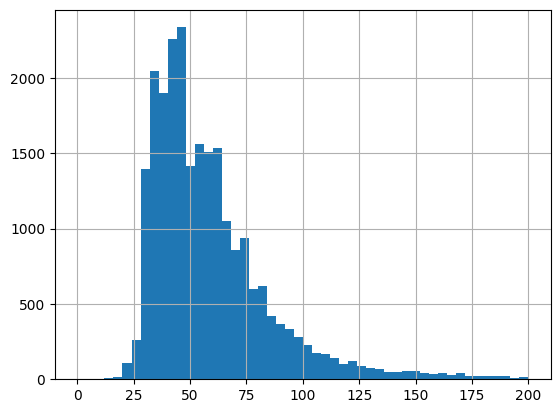

In [21]:
data['total_area'].hist(bins=50, range=(0,200))

In [22]:
len(data.query('total_area > 175'))

340

Мы видим, что присутствуют аномально маленькие значения. Ограничим площадь квартиры 20 кв.м. снизу <br>
Также заметим, что для площади > 175 "хвост" гистограммы становится почти незаметным. Ограничим верхний предел площади квартиры 175 кв.метрами. Таких значений к тому же не так много

In [23]:
data = data.query('total_area >= 20 and total_area <= 175')
data.reset_index(drop=True, inplace=True)

In [24]:
data['total_area'].describe()

count    23332.000000
mean        57.606578
std         25.017674
min         20.000000
25%         40.000000
50%         51.600000
75%         68.300000
max        175.000000
Name: total_area, dtype: float64

Для заполнения пропущенных значений в высоте потолка напишем функцию, разделяющую квартиры на категории по площади. 

In [25]:
def total_area_category(total_area):
    if 20 <= total_area <= 36:
        return 1
    elif 37 <= total_area <= 42:
        return 2
    elif 43 <= total_area <= 54:
        return 3
    elif 55 <= total_area <= 62:
        return 4
    elif 63 <= total_area <= 70:
        return 5
    elif 71 <= total_area <= 83:
        return 6
    else:
        return 7

In [26]:
data['total_area_category'] = data['total_area'].apply(total_area_category)

In [27]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,7
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,4
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,7
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,7


Заполним высоту потолков медианой по категории площади

In [28]:
data['ceiling_height'] = data['ceiling_height']\
    .fillna(data.groupby('total_area_category')['ceiling_height'].transform('median'))

#### Пропуски в `living_area`

__Возможные причины пропусков__ <br>
Поле жилой площади является необязательным при подаче объявления, часть пользователей его решила не заполнять.

Для обработки пропусков в `living_area` изучим матрицу корреляции.

In [29]:
data[data.select_dtypes('number').columns].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
total_images,1.000000,0.134708,0.118807,0.095873,0.005439,0.012768,0.106463,0.030654,0.095828,0.049819,-0.003517,-0.044388,0.015409,-0.007585,-0.017156,-0.001228,-0.030698,0.122788
last_price,0.134708,1.000000,0.710528,0.413181,0.093884,0.043970,0.588773,0.051449,0.562383,0.027444,-0.030222,-0.308121,0.200009,-0.008546,0.209509,-0.113577,0.117421,0.521947
total_area,0.118807,0.710528,1.000000,0.787541,0.094635,-0.050657,0.921687,-0.024358,0.556290,0.035132,-0.026489,-0.239322,0.153178,-0.010920,0.163222,-0.089203,0.160895,0.826990
rooms,0.095873,0.413181,0.787541,1.000000,0.052669,-0.226170,0.873178,-0.159927,0.178151,-0.006792,-0.056451,-0.159981,0.112805,-0.052298,0.072844,-0.041360,0.115573,0.730169
ceiling_height,0.005439,0.093884,0.094635,0.052669,1.000000,-0.022724,0.084369,-0.010811,0.076646,0.034858,-0.017935,-0.074210,0.051786,-0.015758,0.064626,-0.045850,0.017347,0.084564
floors_total,0.012768,0.043970,-0.050657,-0.226170,-0.022724,1.000000,-0.172411,0.677732,0.212366,0.171930,0.106858,0.010134,-0.248708,0.096960,-0.117015,0.032456,-0.049110,-0.034829
living_area,0.106463,0.588773,0.921687,0.873178,0.084369,-0.172411,1.000000,-0.115174,0.300348,0.001050,-0.056442,-0.225141,0.165674,-0.047294,0.133000,-0.063834,0.143734,0.774703
floor,0.030654,0.051449,-0.024358,-0.159927,-0.010811,0.677732,-0.115174,1.000000,0.158404,0.167727,0.069670,0.005608,-0.162501,0.072541,-0.074025,0.022352,-0.039526,-0.022224
kitchen_area,0.095828,0.562383,0.556290,0.178151,0.076646,0.212366,0.300348,0.158404,1.000000,0.063632,0.013845,-0.181203,0.062423,0.036128,0.135507,-0.096673,0.096603,0.436239
balcony,0.049819,0.027444,0.035132,-0.006792,0.034858,0.171930,0.001050,0.167727,0.063632,1.000000,0.049384,0.063272,-0.076360,0.029668,-0.037625,0.017230,-0.028510,0.049745


В матрице корреляции видно, что `living_area` сильно коррелирует с количеством комнат в квартире.

Заполним пропуски в `living_area`, исходя из медианного значения жилой площади для количества комнат.

In [30]:
for rn in data['rooms'].unique():
    data.loc[(data['living_area'].isna()) & (data['rooms'] == rn), 'living_area'] = round(data[data['rooms'] == rn]['living_area'].median(), 2)

Убедимся, что пропусков не осталось

In [31]:
data.query('living_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category


#### Пропуски в `days_exposition`

Посмотрим статистику по `days_exposition`

In [32]:
data['days_exposition'].describe()

count    20228.000000
mean       179.476172
std        218.044274
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

Изучим, как менялось кол-во пустых записей в days_exposition с течением времени.

<Axes: xlabel='year,quarter'>

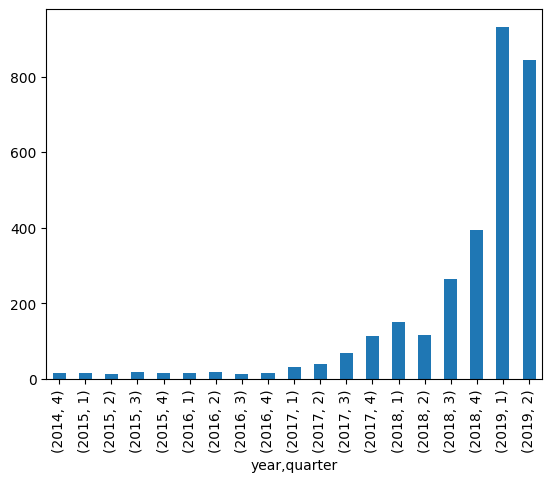

In [33]:
dates = data.query('days_exposition.isna()')[['days_exposition', 'first_day_exposition']]

dates['year'] = pd.DatetimeIndex(dates['first_day_exposition']).year
dates['quarter'] = pd.DatetimeIndex(dates['first_day_exposition']).quarter
dates['month'] = pd.DatetimeIndex(dates['first_day_exposition']).month

dates.groupby(['year', 'quarter'])['first_day_exposition'].count().plot.bar()

__Возможная причина пропусков__ <br>
<!-- Так как этот слолбец хранит информацию о том, сколько дней было размещено обяъвление, а в статистике минимальное значение - это 1 день, можно предположить, что пропуски имеют объявления, снятые в день подачи. <br>
Заполним пропущенные значения значением "0" -->

Так как с 2014 по 1 квартал 2019 года количество пропусков в `days_exposition` почти стабильно росло, можно предположить, что записи, имеющие пропуски в `days_exposition` - это объявления, все еще присутствующие на сайте на момент выгрузки данных. <br> 
Так как у нас нет информации о том, когда произошли продажи по этим объявлениям, и произошли ли они вообще, оставим эти пропуски. 

#### Пропуски в `kitchen_area`

__Возможные причины пропусков__ <br>
Поле площади кухни является необязательным при подаче объявления, часть пользователей его решила не заполнять.

Заполним пропуски в kitchen_area, исходя из категории общей площади.

In [34]:
for cat in data['total_area_category'].unique():
    data.loc[(data['kitchen_area'].isna()) & (data['total_area_category'] == cat), 'kitchen_area'] = round(data[data['total_area_category'] == cat]['kitchen_area'].median(), 2)

In [35]:
data.query('kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category


#### Пропуски в `floors_total`             

__Возможные причины пропусков__ <br>
Поле площади кухни является необязательным при подаче объявления, часть пользователей его решила не заполнять.

Так как пропуски в кол-ве этажей составляют небольшую долю данных, удалим записи с незаполненным значением

In [36]:
data = data.dropna(subset=['floors_total'])
data = data.reset_index(drop=True)

In [37]:
data.query('floors_total.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category


#### Пропуски в `locality_name`             

Так как пропуски в названии населенного пункта составляют небольшую долю данных, к тому же это важные для дальнейшего анализа данные, удалим записи с незаполненным значением

In [38]:
data = data.dropna(subset=['locality_name'])
data = data.reset_index(drop=True)

In [39]:
data.query('locality_name.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category


#### Вывод

In [40]:
data.isna().sum().sort_values(ascending=False)

parks_nearest           15397
ponds_nearest           14414
airports_nearest         5508
cityCenters_nearest      5488
ponds_around3000         5487
parks_around3000         5487
days_exposition          3094
total_images                0
kitchen_area                0
locality_name               0
balcony                     0
open_plan                   0
last_price                  0
studio                      0
is_apartment                0
floor                       0
living_area                 0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
total_area_category         0
dtype: int64

На этапе 2.1. были обработаны пропуски во всех колонках, за исключением картографических. <br>
- Пропуски в `is_apartment` были заполнены значением `False`
- Пропуски в `balcony` были заполнены значением 0 
- Пропуски в `days_exposition` были заполнены значением 0 
- Пропуски в `ceiling_height` были заполнены медианным значением для той же категории площади квартиры (был добавлен столбец) 
- Пропуски в `kitchen_area` были заполнены медианным значением для той же категории площади квартиры  
- Пропуски в `living_area` были заполнены медианным значением для того же кол-ва комнат в квартире 
- Записи с пропусками в `floors_total` были удалены 
- Записи с пропусками в `locality_name` были удалены 

### Изменение типов данных

Применив метод `info()` мы увидели, что данные необходимо изменить в следующих колонках :
- `first_day_exposition` : string -> date
- `days_exposition` : float -> int
- `floors_total` : float -> int
- `balcony` : float -> int
- `last_price` : float -> int

Изменим типы данных. 

In [41]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [42]:
data['floors_total'] = data['floors_total'].astype('int')

In [43]:
data['balcony'] = data['balcony'].astype('int')

Для удобства восприятия разделим значения в колонке last_price на 1000, округлим и приведем к типу int

In [44]:
data['last_price'] /= 1000

In [45]:
data['last_price'] = data['last_price'].astype('int')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23200 entries, 0 to 23199
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23200 non-null  int64         
 1   last_price            23200 non-null  int32         
 2   total_area            23200 non-null  float64       
 3   first_day_exposition  23200 non-null  datetime64[ns]
 4   rooms                 23200 non-null  int64         
 5   ceiling_height        23200 non-null  float64       
 6   floors_total          23200 non-null  int32         
 7   living_area           23200 non-null  float64       
 8   floor                 23200 non-null  int64         
 9   is_apartment          23200 non-null  bool          
 10  studio                23200 non-null  bool          
 11  open_plan             23200 non-null  bool          
 12  kitchen_area          23200 non-null  float64       
 13  balcony         

#### Вывод

На этапе 2.2. были изменены типы данных во всех колонках, где это возможно. По причине пропусков в `days_exposition` и картографических данных, колонки с этими данными невозможно привести к нужному типу

### Обработка дубликатов

Изучим уникальные значения в колонке `locality_name`, так как в ней потенциально присутсвуют дубликаты

In [47]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Сразу заметим, что часть названий содержит букву "ё". Заменим ее на "е", чтобы облегчить дальнейшую обработку дубликатов

In [48]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

Выведем отсортированный список названий

In [49]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалево',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Будогощь',
 'городской поселок Виллози',
 'городской поселок Лесогорский',
 'городской поселок Мга',
 'городской поселок Назия',
 'городской поселок Новоселье',
 'городской поселок Павлово',
 'городской поселок Рощино',
 'городской поселок Свирьстрой',
 'городской поселок Советский',
 'городской поселок Федоровское',
 'городской поселок Янино-1',
 'деревня

Посмотрим, какие названия дублируются. Для этого напишем функцию, которая будет возвращать название населенного пункта без классификации населенного пункта

In [50]:
def get_name(word):
    for i in range(0, len(word)):
        if (word[i].isupper()):
            return word[i:]

In [51]:
names = pd.DataFrame(columns=['name', 'original_name'])

for locality in data['locality_name'].unique():
    name = get_name(locality)
    new_row = {'name' : name, 'original_name' : locality}
    names = pd.concat([names, pd.DataFrame([new_row])])
    
names.reset_index(drop=True, inplace=True)

names['cnt'] = names.groupby(['name'])['original_name'].transform('count')

names.query('cnt > 1').sort_values(by=['cnt', 'name'], ascending=False)

,name,original_name,cnt
63,Павлово,село Павлово,3
89,Павлово,городской поселок Павлово,3
218,Павлово,поселок городского типа Павлово,3
146,Щеглово,поселок Щеглово,2
235,Щеглово,деревня Щеглово,2
14,Федоровское,деревня Федоровское,2
105,Федоровское,городской поселок Федоровское,2
77,Советский,поселок городского типа Советский,2
259,Советский,городской поселок Советский,2
113,Рябово,поселок Рябово,2


Увидим, что можно объединить названия, содержащие "поселок"

In [52]:
duplicate = ['городской поселок', 'поселок городского типа', 'коттеджный поселок', 'поселок при железнодорожной станции', 'поселок станции']
replace_to = 'поселок'

In [53]:
data['locality_name'] = data['locality_name'].replace(duplicate, replace_to, regex=True)

Убедимся, что все возможные дубликаты были устранены

In [54]:
names = names[0:0]

for locality in data['locality_name'].unique():
    name = get_name(locality)
    new_row = {'name' : name, 'original_name' : locality}
    names = pd.concat([names, pd.DataFrame([new_row])])
    
names.reset_index(drop=True, inplace=True)

names['cnt'] = names.groupby(['name'])['original_name'].transform('count')

names.query('cnt > 1').sort_values(by=['cnt', 'name'], ascending=False)

,name,original_name,cnt
146,Щеглово,поселок Щеглово,2
230,Щеглово,деревня Щеглово,2
14,Федоровское,деревня Федоровское,2
105,Федоровское,поселок Федоровское,2
95,Рахья,поселок Рахья,2
158,Рахья,садовое товарищество Рахья,2
149,Рабитицы,деревня Рабитицы,2
304,Рабитицы,поселок Рабитицы,2
145,Приладожский,поселок Приладожский,2
297,Приладожский,садовое товарищество Приладожский,2


#### Вывод 

На этапе 2.3. путем приведения категории населенного пункта к одному виду были устранены дубликаты в колонке `locality_name`

### Обработка аномалий

#### Аномалии в `ceiling_height`

Изучим статистику по высоте потолков

In [55]:
data['ceiling_height'].describe()

count    23200.000000
mean         2.717591
std          0.997168
min          1.000000
25%          2.550000
50%          2.600000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

Построим диаграмму размаха

<Axes: >

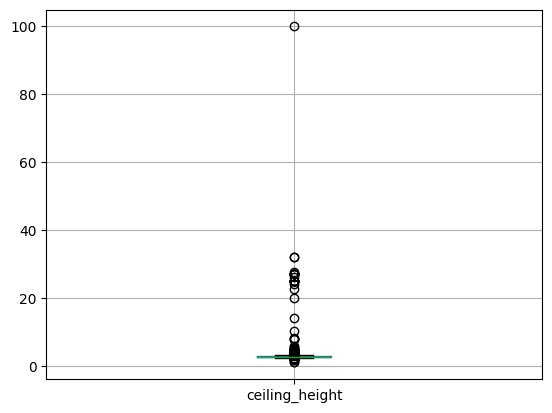

In [56]:
data.boxplot(column='ceiling_height')

Видны явно выбивающиеся значения. Построим гистограммы для разных диапазонов высоты потолка.

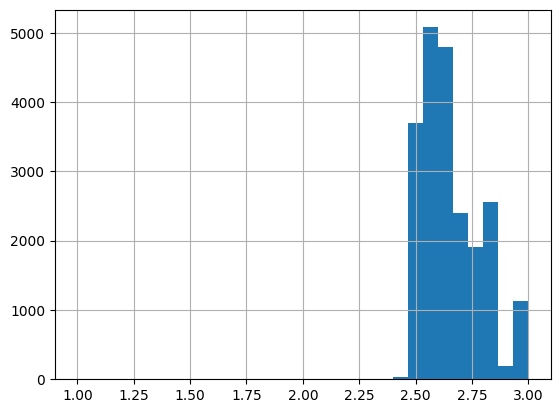

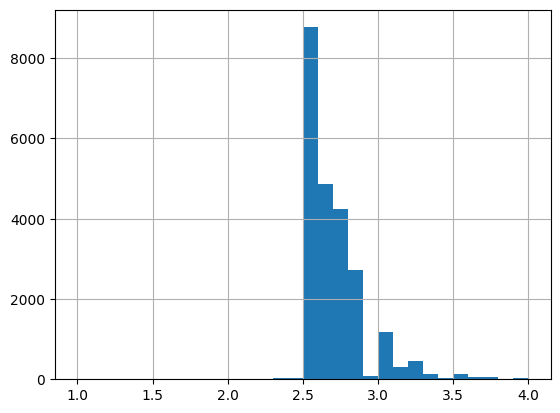

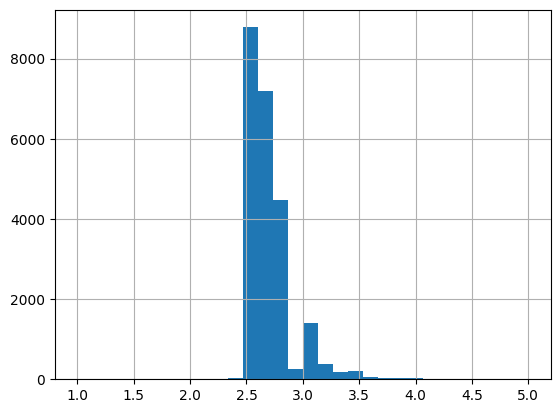

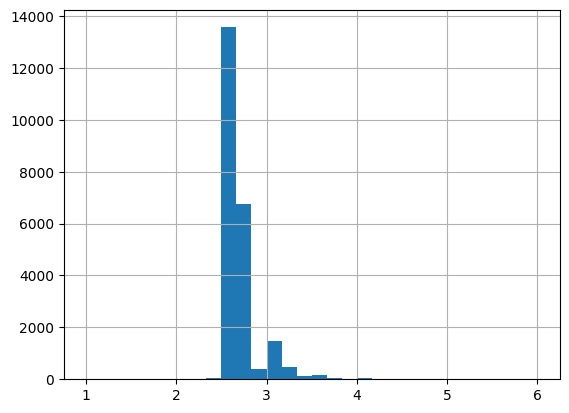

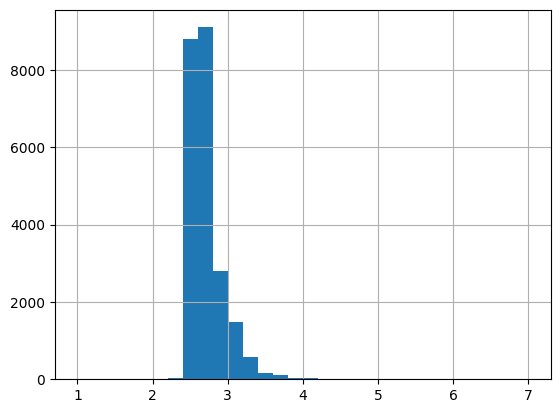

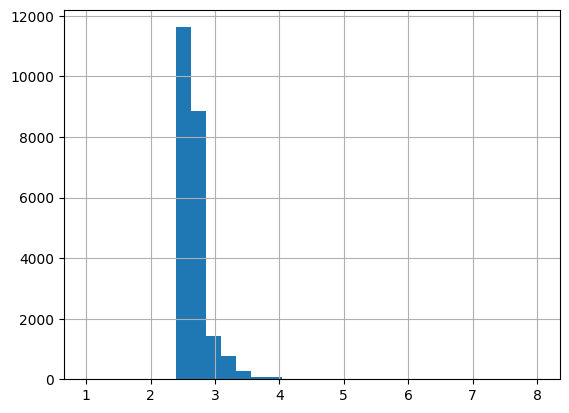

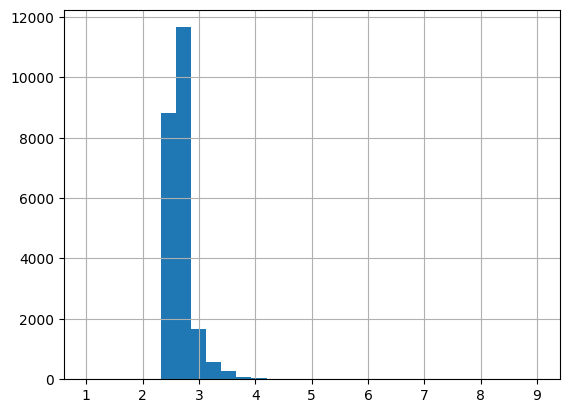

In [57]:
for i in range (3, 10):
    data['ceiling_height'].hist(bins=30, range=(1,i))
    plt.show()

Видим, что бОльшая часть высот лежит в диапазоне 2.4..4 метра. Изучим значения, выбивающиеся из этого диапазона

In [58]:
data.query('ceiling_height < 2.4 or ceiling_height > 4').sort_values(by='ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
22116,16,6000,55.0,2018-10-31,2,1.00,12,32.4,7,False,False,False,10.00,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,4
5590,5,1500,42.8,2017-08-14,2,1.20,2,27.5,1,False,False,False,5.20,0,поселок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,7
16571,5,4100,40.0,2017-10-17,1,1.75,37,17.4,5,False,False,False,8.34,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,2
18928,5,1700,40.0,2018-07-15,2,2.00,9,30.5,8,False,False,False,10.00,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0,2
16099,6,12300,88.3,2019-03-12,3,2.00,5,63.9,2,False,False,False,12.00,0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,0,2500,54.0,2017-10-13,2,27.00,5,30.0,3,False,False,False,9.00,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,3
20930,19,4900,42.0,2017-04-18,1,27.50,24,37.7,19,False,False,False,11.00,2,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0,2
3076,14,2900,75.0,2018-11-12,3,32.00,3,53.0,2,False,False,False,8.00,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
21869,19,9999,92.4,2019-04-05,2,32.00,6,55.5,5,False,False,False,16.50,4,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN,7


Видны явные выбросы - 1,2, 100 метров. При этом можно заметить, что есть ряд высот, которые можно привести к адекватным значениям - например, 27 или 32 - это, скорее всего, 2.7 и 3.2 метра соответственно. Для высот от 24 (2.4 метра - это минимальная норма высоты потолка в России) до 32 заменим их на значения, разделенные на 10. Остальные данные будем считать выбросами и удалим их.

In [59]:
data.loc[(data['ceiling_height'] >= 24) & (data['ceiling_height'] <= 32), 'ceiling_height'] /= 10

Посмотрим, сколько осталось выбросов.

In [60]:
len(data.query('ceiling_height < 2.4 or ceiling_height > 4'))

63

In [61]:
"{:.3%}".format(len(data.query('ceiling_height < 2.4 or ceiling_height > 4'))/ len(data), 5)

'0.272%'

После приведения части значений к нормальному виду, осталось 63 выброса. Это составляет менее 1/3 процента, поэтому эти данные мы можем спокойно удалить.  

In [62]:
data = data.query('2.4 <= ceiling_height <= 4')
data = data.reset_index(drop=True)

In [63]:
data['ceiling_height'].describe()

count    23137.000000
mean         2.687533
std          0.203466
min          2.400000
25%          2.550000
50%          2.600000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64

Путем очистки данных мы уменьшили страндартное отклонение с 0.995516 до 0.205654

#### Аномалии в `living_area`

In [64]:
data['living_area'].describe()

count    23137.000000
mean        32.789597
std         16.352206
min          2.000000
25%         18.300000
50%         30.000000
75%         42.000000
max        140.000000
Name: living_area, dtype: float64

<Axes: >

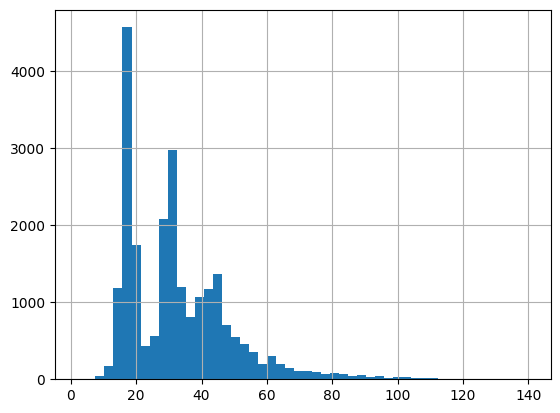

In [65]:
data['living_area'].hist(bins=50)

Заметим, что после 80 кв.м. хвост диаграммы практически сливается с 0. Ограничим жилую площадь 80 кв.м. сверху

In [66]:
data = data.query('living_area <= 80')
data.reset_index(drop=True, inplace=True)

Добавим в датафрейм колонку, показывающую, какую долю в квартире занимает жилая площадь. 

In [67]:
data['living_area_share'] = data['living_area'] / data['total_area']

In [68]:
data['living_area_share'].describe()

count    22712.000000
mean         0.561436
std          0.108003
min          0.021583
25%          0.488889
50%          0.564516
75%          0.635165
max          1.486905
Name: living_area_share, dtype: float64

<Axes: >

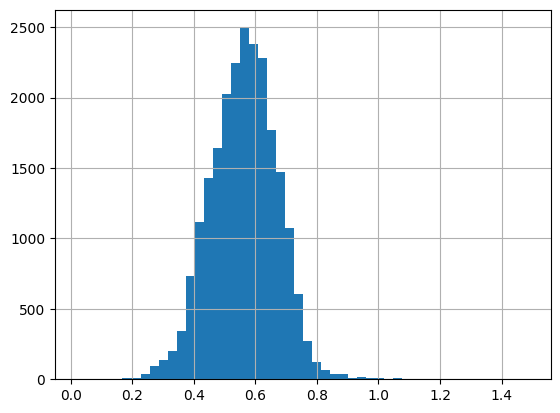

In [69]:
data['living_area_share'].hist(bins=50)

Определим границы lower_bound, upper_bound для удаления выбросов.

In [70]:
q1 = data['living_area_share'].quantile(0.25) 
q3 = data['living_area_share'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

lower_bound, upper_bound

(0.2694753143162245, 0.8545781798433296)

Удалим записи, не попадающие в интервал между нижней и верхней границей

In [71]:
data = data.query('@lower_bound < living_area_share < @upper_bound')
data.reset_index(drop=True, inplace=True)

In [72]:
data['living_area'].describe()

count    22497.000000
mean        31.651256
std         14.011881
min          8.300000
25%         18.200000
50%         30.000000
75%         41.000000
max         80.000000
Name: living_area, dtype: float64

#### Аномалии в `kitchen_area`

Посмотрим статистику по площади кухни

In [73]:
data['kitchen_area'].describe()

count    22497.000000
mean        10.045681
std          4.779465
min          1.300000
25%          7.200000
50%          9.000000
75%         11.300000
max         93.000000
Name: kitchen_area, dtype: float64

Заметим, что минимальное значение - аномально маленькое, 1.3 кв.м. Изучим гистограммы для значений [0..12] и [12..94]

<Axes: >

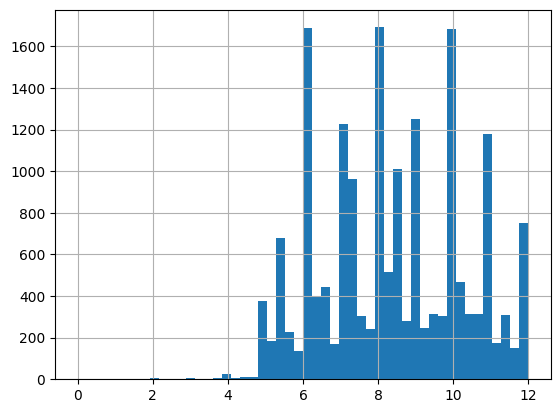

In [74]:
data['kitchen_area'].hist(bins=50, range=(0, 12))

<Axes: >

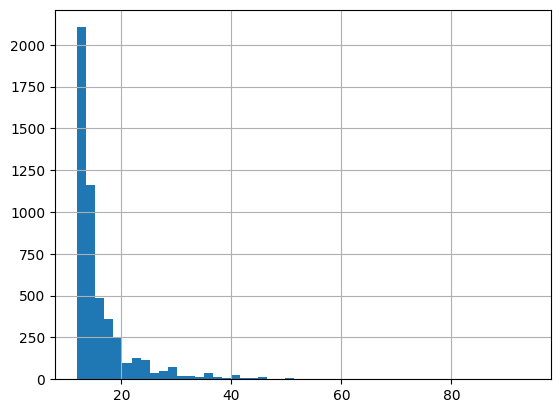

In [75]:
data['kitchen_area'].hist(bins=50, range=(12, 94))

Удалим записи, у которых площадь кухни меньше 5 или больше 20.

In [76]:
data = data.query('5 <= kitchen_area <= 20')
data.reset_index(drop=True, inplace=True)

In [77]:
data['kitchen_area'].describe()

count    21705.000000
mean         9.466979
std          3.054770
min          5.000000
25%          7.100000
50%          9.000000
75%         11.000000
max         20.000000
Name: kitchen_area, dtype: float64

Добавим колонку, показывающую долю кухни в площади квартиры.

In [78]:
data['kitchen_area_share'] = data['kitchen_area'] / data['total_area']

Как и с долей жилой площади, удалим записи, дял которых доля кухни не попадает в интервал

In [79]:
q1 = data['kitchen_area_share'].quantile(0.25) 
q3 = data['kitchen_area_share'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

lower_bound, upper_bound

(-0.003775452488687714, 0.371677036199095)

In [80]:
data = data.query('@lower_bound < kitchen_area_share < @upper_bound')
data.reset_index(drop=True, inplace=True)

In [81]:
data['kitchen_area'].describe()

count    21532.000000
mean         9.409791
std          2.993185
min          5.000000
25%          7.100000
50%          9.000000
75%         11.000000
max         20.000000
Name: kitchen_area, dtype: float64

Теперь посмотрим, какие данные имеют некорректно заполненные поля площади, т.е. те, в которых сумма жилой площади и кухни превосходит общую площадь.

In [82]:
data.query('living_area + kitchen_area > total_area').loc[:, :'kitchen_area']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area
146,6,800,40.3,2018-06-25,2,2.65,3,30.5,1,False,False,False,10.0
490,9,4700,23.8,2018-12-28,1,2.55,18,20.0,9,False,False,False,5.0
522,13,3500,38.0,2017-07-10,2,2.65,9,30.5,8,False,False,False,10.0
545,2,1850,25.0,2019-02-20,0,2.55,10,18.0,7,False,True,False,7.3
615,12,2500,24.1,2017-12-01,0,2.75,25,17.5,21,False,True,False,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201,6,3100,27.3,2018-05-29,0,2.70,16,23.3,15,False,True,False,7.3
20585,6,3150,24.0,2019-04-16,1,2.55,5,17.6,3,False,False,False,7.3
20601,4,2100,23.6,2016-02-25,1,2.75,25,17.7,23,False,False,False,7.3
20791,5,2450,42.5,2018-06-28,2,2.50,4,30.5,4,False,False,False,13.0


Обработаем эти значения

In [83]:
incorrect_area_data = data.query('living_area + kitchen_area > total_area')

In [84]:
incorrect_area_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share
146,6,800,40.3,2018-06-25,2,2.65,3,30.5,1,False,False,False,10.0,2,поселок Ефимовский,NaN,NaN,NaN,NaN,NaN,NaN,81.0,2,0.756824,0.248139
490,9,4700,23.8,2018-12-28,1,2.55,18,20.0,9,False,False,False,5.0,0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0,1,0.840336,0.210084
522,13,3500,38.0,2017-07-10,2,2.65,9,30.5,8,False,False,False,10.0,0,Санкт-Петербург,11058.0,12575.0,0.0,NaN,0.0,NaN,3.0,2,0.802632,0.263158
545,2,1850,25.0,2019-02-20,0,2.55,10,18.0,7,False,True,False,7.3,0,поселок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,1,0.720000,0.292000
615,12,2500,24.1,2017-12-01,0,2.75,25,17.5,21,False,True,False,7.3,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0,1,0.726141,0.302905


Для обработки таких значений рассчитаем коэффиент, показывающий, во сколько раз сумма площади кухни и жилой площади превосходит общую

In [85]:
ratios = incorrect_area_data['total_area'] / (incorrect_area_data['kitchen_area'] +  incorrect_area_data['living_area'])

In [86]:
data.loc[ratios.index, 'kitchen_area'] = (data.loc[ratios.index, 'kitchen_area'] * ratios).apply(lambda x : math.floor(x))
data.loc[ratios.index, 'living_area'] = (data.loc[ratios.index, 'living_area'] * ratios).apply(lambda x : math.floor(x))

Убедимся, что не осталось некорректных данных

In [87]:
data.query('living_area + kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share


#### Аномалии в `floors_total`

Изучим статистику по количеству этажей в доме 

In [88]:
data['floors_total'].describe()

count    21532.000000
mean        10.763236
std          6.578878
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Построим гистограммы для разных значений кол-ва этажей

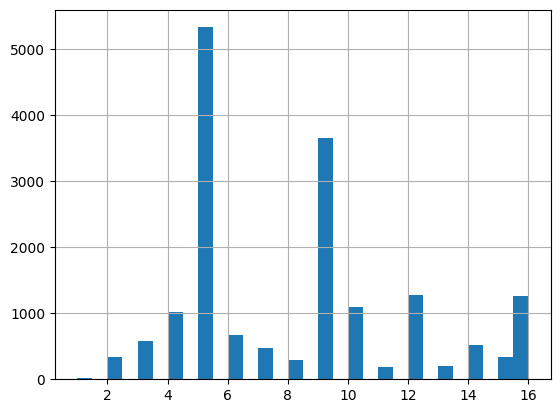

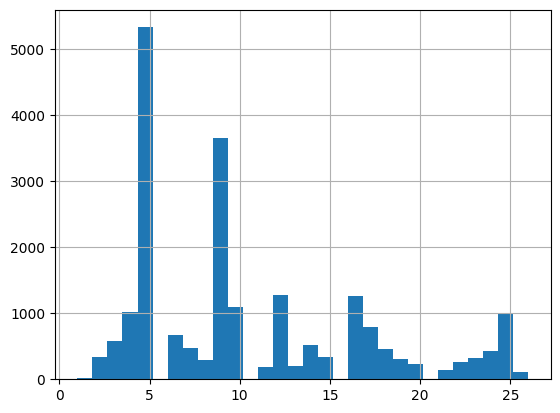

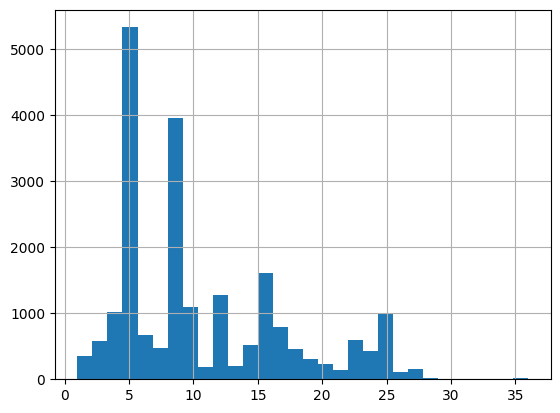

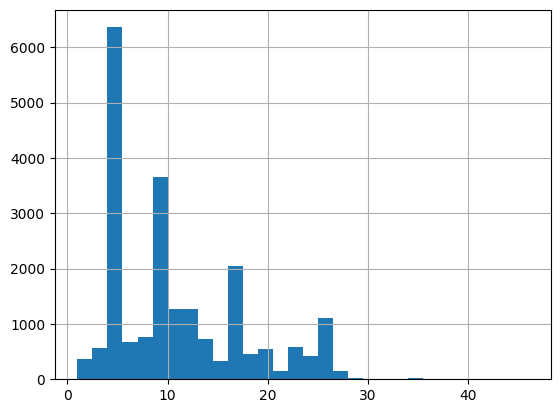

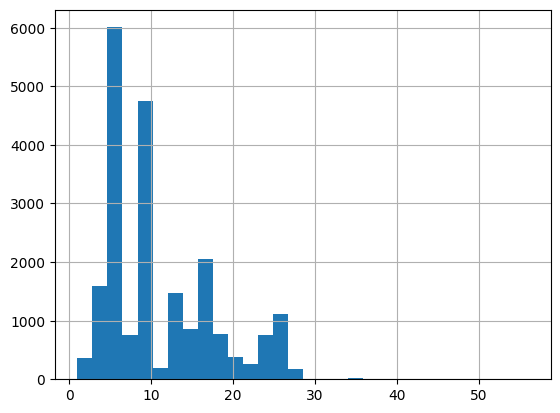

In [89]:
for i in range(16, 60, 10):
    data['floors_total'].hist(bins=30, range=(1,i))
    plt.show()

На гистограммах видно, что записи с 30+ этажами встречаются очень редко. Изучим их с целью возможной обработки 

In [90]:
data.query('floors_total >= 30')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share
358,15,5990,54.0,2018-03-22,2,2.585,36,21.4,28,False,False,False,18.7,1,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0,3,0.396296,0.346296
770,14,7777,75.0,2017-11-16,2,2.750,35,40.5,23,False,False,False,11.7,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,169.0,6,0.540000,0.156000
1526,11,3550,28.0,2018-02-08,1,2.650,34,18.0,23,False,False,False,7.3,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,410.0,1,0.642857,0.260714
1730,13,10150,74.0,2017-11-17,2,2.800,35,34.4,30,False,False,False,13.0,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN,6,0.464865,0.175676
2036,12,3800,45.5,2018-06-28,2,2.880,60,27.4,4,False,False,False,7.4,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0,3,0.602198,0.162637
2681,9,4300,37.0,2017-08-08,1,2.650,35,14.0,15,False,False,False,10.4,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,50.0,2,0.378378,0.281081
4400,12,5500,50.0,2017-06-22,1,2.800,35,22.0,4,False,False,False,13.0,0,Санкт-Петербург,18627.0,20339.0,1.0,609.0,3.0,145.0,537.0,3,0.440000,0.260000
5229,20,3590,25.0,2017-08-30,0,2.800,35,17.0,26,False,False,True,7.0,2,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,198.0,1,0.720000,0.292000
5284,17,8150,80.0,2019-01-09,2,2.700,36,41.0,13,False,False,False,12.0,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,6,0.512500,0.150000
5285,12,4590,43.0,2018-10-19,1,2.585,35,14.0,11,False,False,False,15.0,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,82.0,3,0.325581,0.348837


По данным на 2019 год, самое высокое жилое здание в Санкт-Петегрбурге (Жилой Комплекс «Князь Александр Невский») имело 37 этажей. Однако в данных присутствует запись с 60 этажами в Кронштадте. Это явный выброс, удалим его. 

In [91]:
data = data.query('floors_total <= 37')
data.reset_index(drop=True, inplace=True)

In [92]:
data['floors_total'].describe()

count    21531.000000
mean        10.760949
std          6.570468
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

#### Аномалии в `last_price`

Изучим статистику по `last_price`

In [93]:
data['last_price'].describe()

count     21531.000000
mean       5347.729274
std        3809.088478
min         430.000000
25%        3370.000000
50%        4500.000000
75%        6260.000000
max      124000.000000
Name: last_price, dtype: float64

Изучим записи, для которых цена лежит в диапазоне 6400..124000

In [94]:
data.query('6400 <= last_price <= 124000').sort_values(by='last_price', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share
4530,20,124000,124.5,2017-10-12,4,3.000,4,67.2,2,False,False,False,20.0,0,Санкт-Петербург,20399.0,1722.0,3.0,302.0,3.0,172.0,45.0,7,0.539759,0.160643
15073,10,98000,155.0,2017-12-16,3,2.800,8,45.0,6,False,False,False,13.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,90.0,7,0.290323,0.083871
5872,2,82000,114.0,2015-12-17,3,2.800,5,78.5,4,False,False,False,20.0,0,Санкт-Петербург,22460.0,3400.0,2.0,218.0,3.0,69.0,651.0,7,0.688596,0.175439
14280,7,77349,135.7,2017-12-16,3,2.800,7,45.0,5,False,False,False,13.0,0,Санкт-Петербург,32950.0,6042.0,3.0,362.0,3.0,246.0,90.0,7,0.331614,0.095800
12617,12,65000,129.0,2017-09-25,3,2.800,6,72.0,5,False,False,False,19.0,0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,13.0,7,0.558140,0.147287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13321,7,6400,67.2,2017-04-20,3,2.750,10,42.5,10,False,False,False,8.2,0,Санкт-Петербург,9655.0,13255.0,1.0,980.0,1.0,1093.0,690.0,5,0.632440,0.122024
3183,20,6400,65.7,2017-11-29,3,2.500,10,42.7,9,False,False,False,7.0,0,Санкт-Петербург,13652.0,11927.0,0.0,NaN,1.0,504.0,240.0,5,0.649924,0.106545
19016,18,6400,55.9,2017-04-27,1,2.600,17,29.2,11,False,False,False,9.3,0,Санкт-Петербург,32866.0,13783.0,0.0,NaN,1.0,836.0,60.0,4,0.522361,0.166369
15559,10,6400,53.5,2017-11-10,2,2.585,25,30.0,11,False,False,False,11.0,1,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,144.0,3,0.560748,0.205607


Изучим гистограмму для значений 6400..124000

<Axes: >

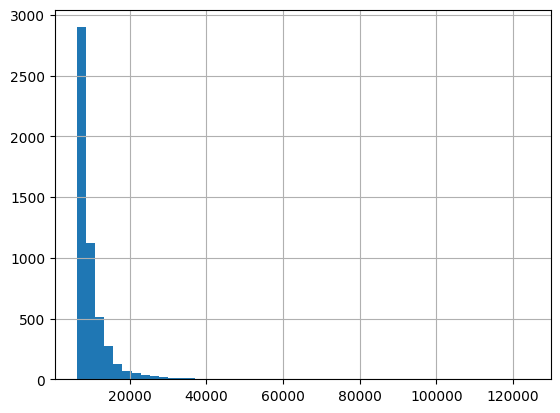

In [95]:
data['last_price'].hist(bins=50, range=(6400, 124000))

Выведем диаграмму размаха для колонки `last_price`

<Axes: >

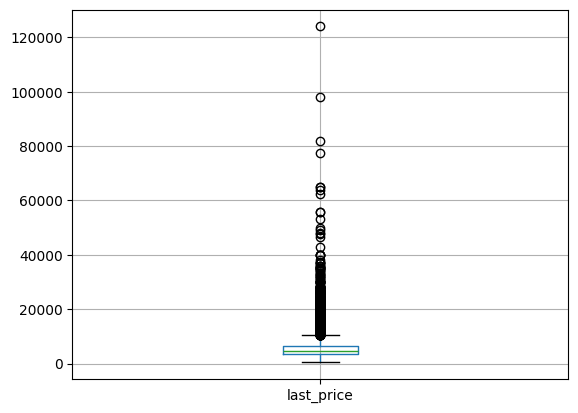

In [96]:
data.boxplot(column='last_price')

<Axes: >

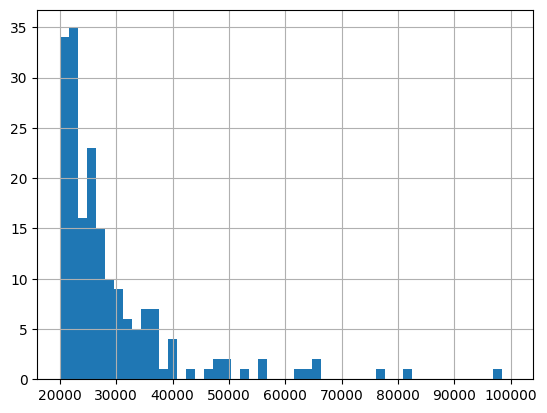

In [97]:
data['last_price'].hist(bins=50, range=(20000,100000))

Исходя из полученных данных, ограничим цену сверху значением 20000тыс.

In [98]:
data = data.query('last_price <= 20000')
data.reset_index(drop=True, inplace=True)

In [99]:
data['last_price'].describe()

count    21350.000000
mean      5140.125105
std       2819.635236
min        430.000000
25%       3350.000000
50%       4500.000000
75%       6200.000000
max      20000.000000
Name: last_price, dtype: float64

#### Аномалии в `rooms`

Изучим статистику по колонке `rooms`

In [100]:
data['rooms'].describe()

count    21350.000000
mean         1.958876
std          0.907133
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

<Axes: >

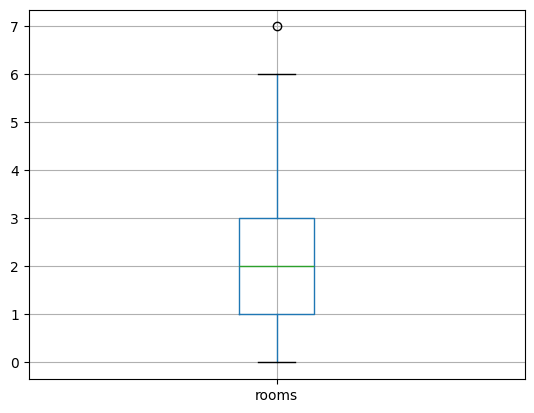

In [101]:
data.boxplot(column='rooms')

<Axes: >

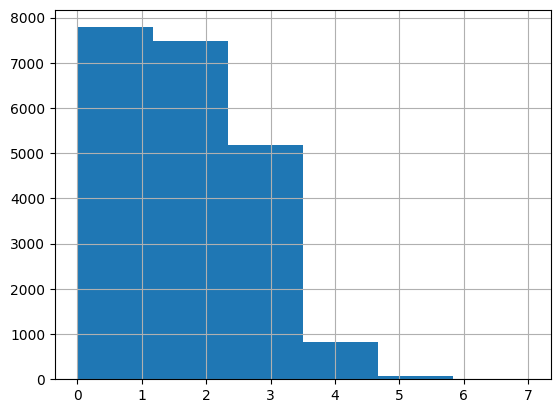

In [102]:
data['rooms'].hist(bins=6)

Удалим записи, для которых количество комнат превосходит 6.

In [103]:
data = data.query('rooms <= 6')
data.reset_index(drop=True, inplace=True)

Также проанализируем, насколько корректно заполнены значения. Найдем записи, в которых тип квартиры не является студией и указанное кол-во комнат равно 0.

In [104]:
data.query('rooms == 0 and not studio')['open_plan'].mean()

1.0

Заметим, что все такие записи имеют True в колонке "свободная планировка". Не будем ничего менять.

Теперь посмотрим, есть ли квартиры-студии, для которых кол-во комнат больше 0

In [105]:
data.query('studio and rooms > 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share
2139,5,2250,25.41,2016-06-07,1,2.55,12,17.08,8,False,True,False,7.3,2,Санкт-Петербург,14125.0,12921.0,2.0,328.0,2.0,485.0,26.0,1,0.672176,0.287288
2858,13,3800,27.00,2016-05-17,1,2.55,14,18.00,8,False,True,False,7.3,2,Санкт-Петербург,50348.0,16053.0,0.0,NaN,0.0,NaN,45.0,1,0.666667,0.270370
3749,4,4500,34.00,2016-04-25,1,2.80,10,21.00,10,False,True,False,7.3,2,Санкт-Петербург,23609.0,5299.0,0.0,NaN,1.0,433.0,62.0,1,0.617647,0.214706
9944,1,2800,28.00,2016-05-04,1,2.55,26,19.00,6,False,True,False,7.3,2,поселок Парголово,53511.0,19687.0,0.0,NaN,0.0,NaN,45.0,1,0.678571,0.260714
11643,10,2200,31.00,2016-05-15,1,2.50,8,22.30,5,False,True,False,7.3,1,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1,0.719355,0.235484
16857,4,2400,22.00,2016-05-06,1,2.55,10,14.00,6,False,True,False,7.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1,0.681818,0.331818
18088,0,1550,22.00,2016-05-11,1,2.70,15,10.94,14,False,True,False,7.3,2,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1,0.497273,0.331818
19543,9,2349,23.40,2016-05-19,1,2.70,20,16.00,8,False,True,False,7.3,1,деревня Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,34.0,1,0.683761,0.311966
20400,5,2650,26.00,2015-06-24,1,2.55,14,15.00,11,False,True,False,7.3,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,373.0,1,0.576923,0.280769


Проставим для них кол-во комнат, равное 0

In [106]:
data.loc[(data['studio']) & (data['rooms'] != 0), 'rooms'] = 0

#### Аномалии в `floor`

Изучим статистику по этажу квартиры

In [107]:
data['floor'].describe()

count    21349.000000
mean         5.875357
std          4.863777
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Насколько знаем, максимальная высота этажа, на котором могли продавать квартиру - 37. Максимальное значение `floor` не превосходит ее.

Посмотрим, нет ли записей, для которых высота этажа превосходит высоту этажей в доме.

In [108]:
data.query('floor > floors_total')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share


Таких записей нет.

#### Аномалии в `airports_nearest`

In [109]:
data['airports_nearest'].describe()

count    16111.000000
mean     28892.170691
std      12887.046265
min          0.000000
25%      18119.000000
50%      27059.000000
75%      37504.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [110]:
data.query('airports_nearest == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,living_area_share,kitchen_area_share
18983,0,7000,34.7,2018-09-23,1,2.7,9,19.8,3,False,False,False,6.0,2,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0,1,0.570605,0.172911


Удалим запись, для которой расстояние до аэропорта - 0 кв.м. Также создадим баг-репорт, т.к. либо пользователь указал, что он продает квартиру в аэропорте, либо алгоритм вычисления расстояния неправильно отработал

In [111]:
data.drop(index=18326, inplace=True)
data.reset_index(drop=True, inplace=True)

#### Аномалии в `parks_nearest`

In [112]:
data['parks_nearest'].describe()

count    6876.000000
mean      493.436446
std       337.252858
min         1.000000
25%       292.000000
50%       458.000000
75%       616.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Расстояние до парка в 1 метр кажется выбросом. Изучим гистограмму для значений 0..200

<Axes: >

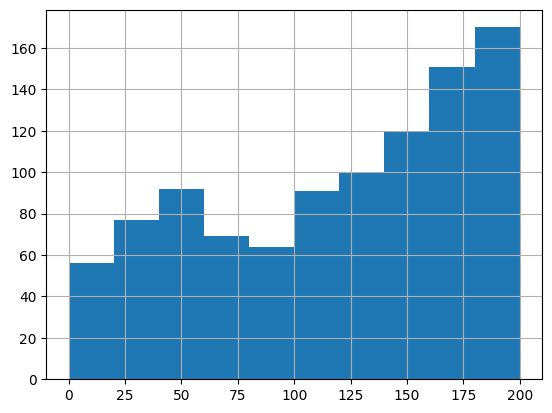

In [113]:
data['parks_nearest'].hist(range=(0,200))

Исходя из здравого смысла, удалим данные, для которых расстояние до парка менее 100 м.

In [114]:
data = data.query('parks_nearest.isna() or parks_nearest >= 100')
data.reset_index(drop=True, inplace=True)

#### Аномалии в `ponds_nearest`

In [115]:
data['ponds_nearest'].describe()

count    7596.000000
mean      530.778568
std       276.115294
min        13.000000
25%       316.000000
50%       517.000000
75%       737.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Изучим гистограмму для значений 0..300

<Axes: >

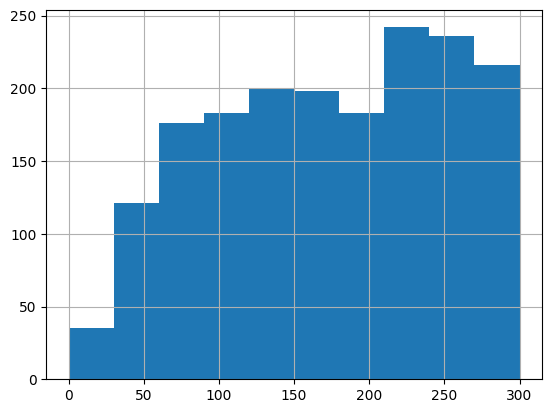

In [116]:
data['ponds_nearest'].hist(range=(0,300))

Также удалим данные, для которых расстояние до водоема менее 100 м.

In [117]:
data = data.query('ponds_nearest.isna() or ponds_nearest >= 100')
data.reset_index(drop=True, inplace=True)

#### Вывод

На этапе 2.4. были обработаны аномалии во всех колонках, где это возможно. <br>
- В `ceiling_height` были удалены выбросы и приведены к нормальному значению высоты, где это было возможно
- В `living_area` были удалены выбросы. Был добавлен столбец `living_area_category`, были удалены строки, в которых доля жилой площади не попадала в [q1 + 1.5 * iqr : q3 + 1.5 * iqr]
- В `kitchen_area` были удалены выбросы. Был добавлен столбец `kitchen_area_category`, были удалены строки, в которых доля площади кухни не попадала в [q1 + 1.5 * iqr : q3 + 1.5 * iqr]
- В `floors_total` были удалены выбросы (этажи выше 37)
- В `last_price` были удалены выбросы (значения больше 20 млн)
- В `rooms` были удалены выбросы (значения больше 6)
- В `floor` аномалии не были обнаружены
- В `airports_nearest` были удалены невозможные значения (расстояние 0 м)
- В `parks_nearest` были удалены строки со значением меньше 100
- В `ponds_nearest` были удалены строки со значением меньше 100

## Добавление новых столбцов

### Добавление столбца `square_meter_price`

In [118]:
data['square_meter_price'] = data['last_price'] / data['total_area']

### Добавление столбца `publication_day_of_week`

In [119]:
data['publication_day_of_week'] = data['first_day_exposition'].dt.weekday

### Добавление столбца `publication_month`

In [120]:
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

### Добавление столбца `publication_year`

In [121]:
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

### Добавление столбца `floor_type`

In [122]:
def get_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [123]:
data['floor_type'] = data.apply(get_floor_type, axis=1)

### Добавление столбца `cityCenters_nearest_km`

In [124]:
def convert_meters_to_kilometers(distance) -> int: 
    if pd.isna(distance):
        return None
    else: 
        return round(distance / 1000)

In [125]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'].apply(convert_meters_to_kilometers)

In [126]:
data.loc[1415, :]

total_images                                10
last_price                                2800
total_area                                31.3
first_day_exposition       2017-10-13 00:00:00
rooms                                        1
ceiling_height                            2.55
floors_total                                 5
living_area                               18.0
floor                                        2
is_apartment                             False
studio                                   False
open_plan                                False
kitchen_area                               6.0
balcony                                      0
locality_name                  Санкт-Петербург
airports_nearest                       11704.0
cityCenters_nearest                    10223.0
parks_around3000                           0.0
parks_nearest                              NaN
ponds_around3000                           1.0
ponds_nearest                            211.0
days_expositi

### Вывод

На этапе 3 были добавлены столбцы, необходимые для дальнейшего исследовательского анализа

## Исследовательский анализ данных

### Изучение параметров объектов

In [127]:
len(data)

20611

После очистки данных от выбросов, в датафрейме осталось 20599 записей. Проведем исследовательский анализ.

### Изучение общей площади

In [128]:
data['total_area'].describe()

count    20611.000000
mean        54.191856
std         19.703866
min         20.000000
25%         39.200000
50%         50.000000
75%         64.910000
max        170.000000
Name: total_area, dtype: float64

Так как на предыдущих этапах мы провели очистку данных, минимальным и максимальным значением площади квартиры стали 20 и 170 кв.м. соответственно. Медианным значением является 50 кв.м. 

Построим гистограмму. 

<Axes: >

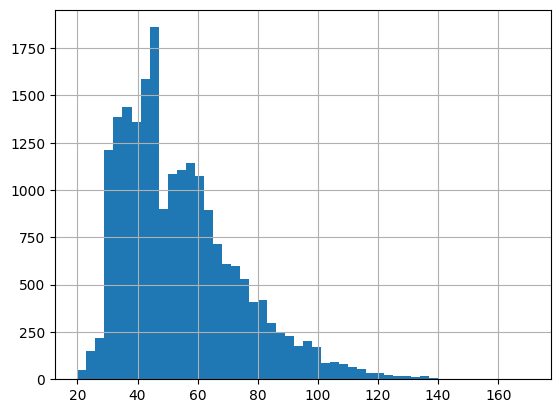

In [129]:
data['total_area'].hist(bins=50)

На гистограмме видно, что большая часть значений попадает в диапазон 30..100 кв.м. <br>
Самое часто встречаемое значение примерно равно 45 кв.м. <br> 
Также виден хвост справа, от 100 до 160 кв.м. Скорее всего, в эти значения попадают элитные квартиры и частные дома. 

### Изучение жилой площади

In [130]:
data['living_area'].describe()

count    20611.000000
mean        31.111129
std         13.456809
min          8.300000
25%         18.000000
50%         30.000000
75%         40.000000
max         80.000000
Name: living_area, dtype: float64

Медианное значение жилой площади - 30 кв.м. Построим гистограмму

<Axes: >

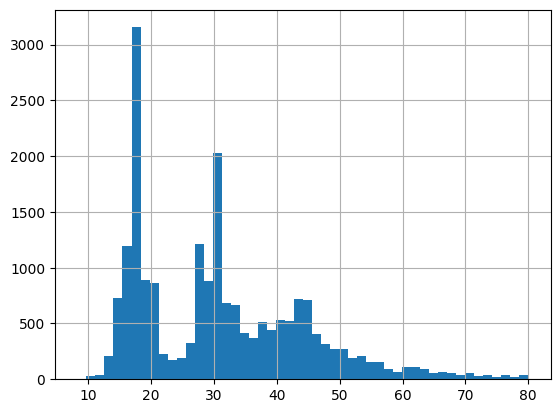

In [131]:
data['living_area'].hist(bins=50)

На гистограмме можно заметить несколько пиков - в районе 18 кв.м, в районе 32 кв.м. и в районе 45 кв.м. Скорее всего, данные пики обусловлены типом квартир с определенным значением жил. площади

### Изучение площади кухни

In [132]:
data['kitchen_area'].describe()

count    20611.000000
mean         9.334426
std          2.947851
min          4.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         20.000000
Name: kitchen_area, dtype: float64

<Axes: >

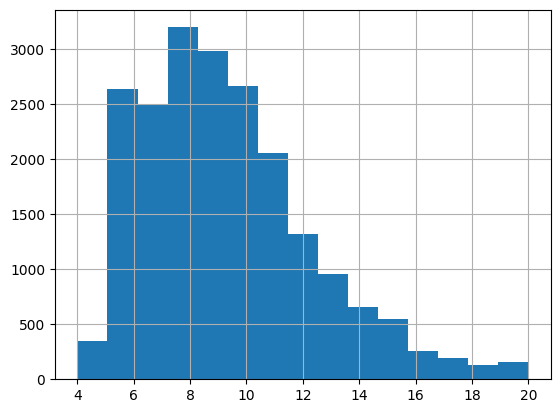

In [133]:
data['kitchen_area'].hist(bins=15)

Чаще всего кухня занимает в квартире от 7 до 8 кв.м. 

### Изучение цены объекта

In [134]:
data['last_price'].describe()

count    20611.000000
mean      5087.205861
std       2785.957066
min        430.000000
25%       3300.000000
50%       4450.000000
75%       6100.000000
max      20000.000000
Name: last_price, dtype: float64

<Axes: >

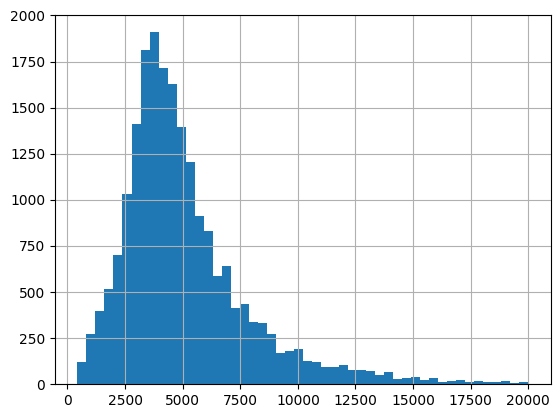

In [135]:
data['last_price'].hist(bins=50)

Гистограмма похожа на нормальное распределение, однако она также имеет хвост справа, от 10000тыс. до 20000тыс. Вероятнее всего, эти цены присущи сектору элитных квартир или коттеджей

### Изучение кол-ва комнат

In [136]:
data['rooms'].describe()

count    20611.000000
mean         1.955364
std          0.906308
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

<Axes: xlabel='rooms'>

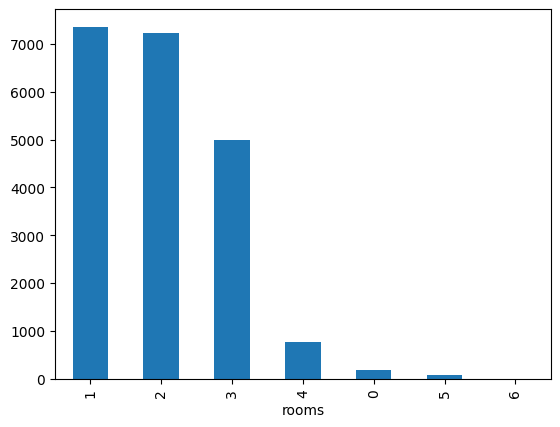

In [137]:
data['rooms'].value_counts().plot.bar()

Количество квартир, имеющих 1 или 2 команты практически одинаково, чуть меньшую долю занимают трехкомнатные квартиры. 0,4,5,6 комнат встречаются значительно реже

### Изучение высоты потолков

In [138]:
data['ceiling_height'].describe()

count    20611.000000
mean         2.668650
std          0.182453
min          2.400000
25%          2.550000
50%          2.600000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64

<Axes: >

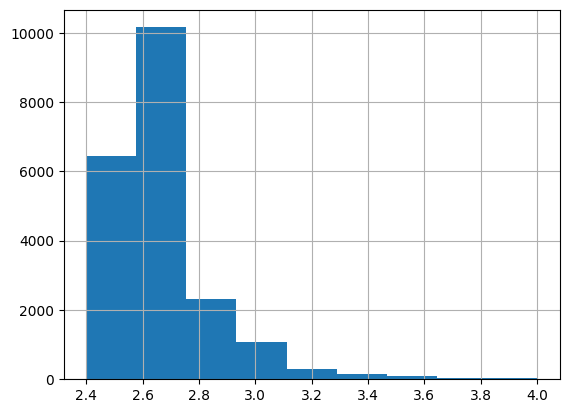

In [139]:
data['ceiling_height'].hist(bins=9)

Самые частые высоты потолков - от 2.6 до примерно 2.7 метра, потолки ниже также встречаются часто, выше - намного реже

### Изучение этажа квартиры

In [140]:
data['floor'].describe()

count    20611.000000
mean         5.869681
std          4.849506
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

<Axes: xlabel='floor'>

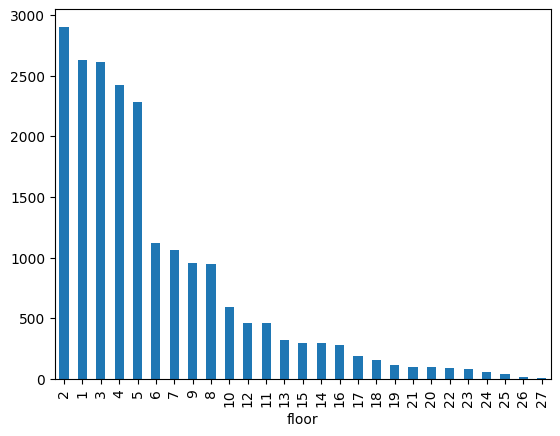

In [141]:
data['floor'].value_counts().plot.bar()

Больше всего квартир расположено на 2 этаже, затем с небольшим отрывом идут 3,1,4,5 этажи. Начиная с 3 этажа заметна почти постоянная тенденция - чем выше этаж, тем меньше квартир с этим этажем продавалось. Скорее всего, данная зависимость обсуловлена преимуществом "хрущевок" на рынке недвижимости, высотки же пока встречаются реже.

### Изучение типа этажа квартиры

<Axes: ylabel='floor'>

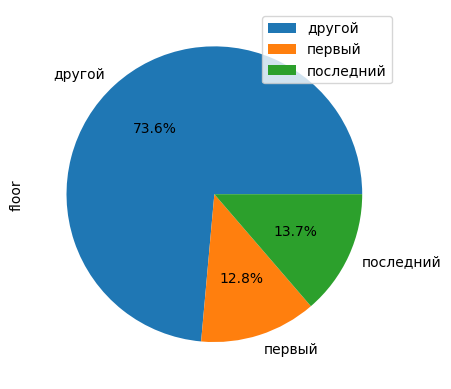

In [142]:
data.groupby('floor_type').count().plot(kind='pie', y='floor', autopct='%1.1f%%')

Примерно равная доля квартир расположена на первом и последнем этажах, большая же часть - между ними

### Изучение общего кол-ва этажей в доме

In [143]:
data['floors_total'].describe()

count    20611.000000
mean        10.756150
std          6.542076
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64

<Axes: xlabel='floors_total'>

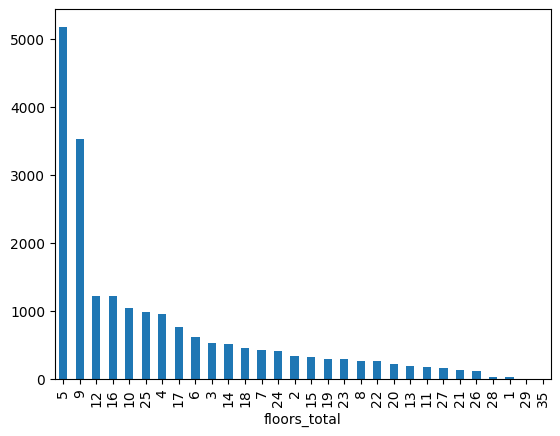

In [144]:
data['floors_total'].value_counts().plot.bar()

"Пятиэтажки" лидируют среди всех данных по количеству этажей в доме, следом за ними идут "Девятиэтажки", затем - 16-ти, 12-ти этажки. Высотные здания встречаются реже.

### Изучение расстояния до центра города в метрах

In [145]:
data['cityCenters_nearest'].describe()

count    15390.000000
mean     14816.192138
std       8420.576899
min        208.000000
25%      10429.500000
50%      13478.000000
75%      16536.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

В данных о расстоянии до цента видим разброс от 208 метров до почти 66 км. 

<Axes: >

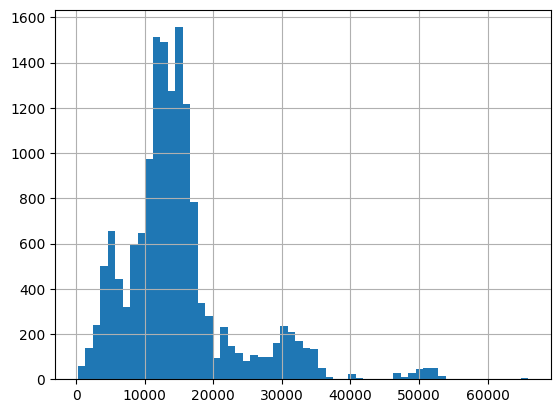

In [146]:
data['cityCenters_nearest'].hist(bins=60)

Гистограмма имеет несколько пиков - в районе 5км, 12-17км, 32км и 51-53км. Большая часть расположена в диапазоне от 11 до примерно 17 км. Вероятно, это то, что принято называть "спальными районами". Отдельные пики на гистограме - это крупные населенные пункты вокруг Санкт-Петербурга.

In [147]:
data.query('30000 <= cityCenters_nearest <= 35000')['locality_name'].value_counts()

locality_name
Колпино              289
Петергоф             130
Пушкин               115
поселок Шушары        97
Сестрорецк            86
Красное Село          57
Павловск              31
поселок Понтонный     20
Name: count, dtype: int64

In [148]:
data.query('50000 <= cityCenters_nearest <= 53000')['locality_name'].value_counts()

locality_name
Ломоносов      107
Кронштадт       24
Зеленогорск      4
Name: count, dtype: int64

### Изучение расстояния до ближайшего аэропорта

In [149]:
data['airports_nearest'].describe()

count    15373.000000
mean     29006.165160
std      12930.838994
min          0.000000
25%      18023.000000
50%      27310.000000
75%      37781.000000
max      84869.000000
Name: airports_nearest, dtype: float64

В данных о расстоянии до аэропорта видим разброс от 6450 метров до почти 85 км. 

<Axes: >

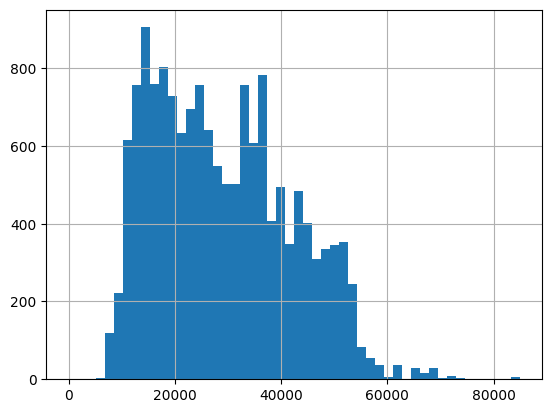

In [150]:
data['airports_nearest'].hist(bins=50)

Наибольшая часть квартир расположена на расстоянии от 10 до 25 км от аэропорта. Также есть пики в районе 33-37 км, 42-45 км, 50-53 км. 

### Изучение расстояния до ближайшего парка

In [151]:
data['parks_nearest'].describe()

count    6284.000000
mean      517.887969
std       329.262258
min       100.000000
25%       320.000000
50%       474.000000
75%       624.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Построим гистограмму

<Axes: >

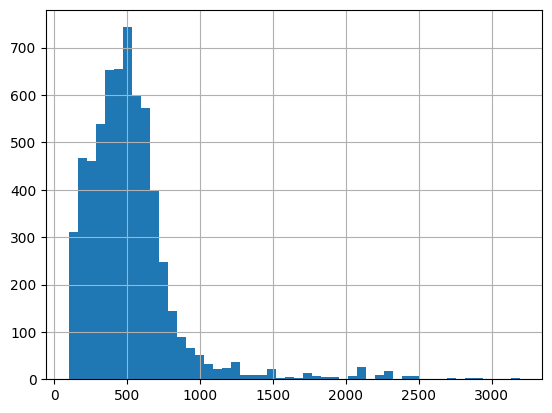

In [152]:
data['parks_nearest'].hist(bins=50)

Основная доля попадает в диапазон расстояний 100..800 метров. Для значений больше 1000 данных очень мало. Самое часто встречаемое значение - примерно 500 м.

### Изучение дня и месяца даты объявления

<Axes: xlabel='publication_day_of_week'>

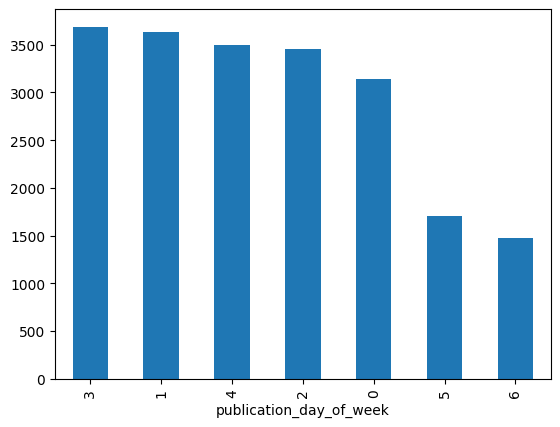

In [153]:
data['publication_day_of_week'].value_counts().plot.bar()

На диаграмме, отображающей частоту, с которой объявления были выложены в разные дни недели можно заметить, что в буднии дни (0..4) объявления выкладывали примерно одинаково часто. В выходные же дни объявления выкладывались более чем в 2 раза реже. 

<Axes: xlabel='publication_month'>

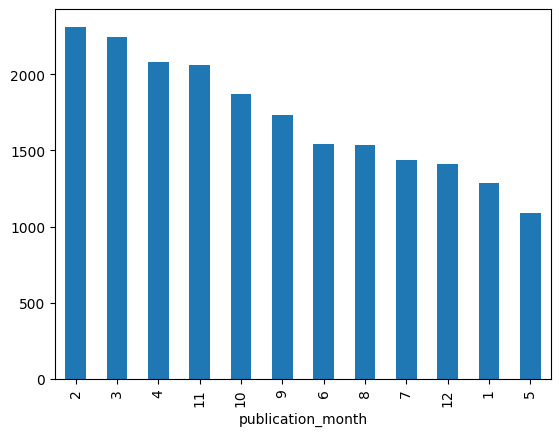

In [154]:
data['publication_month'].value_counts().plot.bar()

Чаще всего объявления о продаже недвижимости выкладывали в феврале и марте, чуть реже - в апреле. Следующая тройка лидеров - это осенние месяцы, за ними идет лето, декабрь, январь, и реже всего встречается май. <br>
Возможно, пик активности, выпадающий на февраль..апрель связан с сезонным настроением рынка, люди активнее начинают искать и продавать квартиры ближе к концу зимы - началу весны. Трудно сказать, с чем связан майский спад активности. 

### Изучение времени продажи квартир

<Axes: >

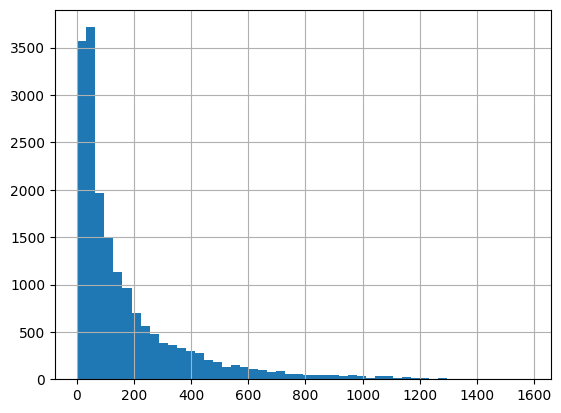

In [155]:
data['days_exposition'].hist(bins=50)

In [156]:
data['days_exposition'].describe()

count    18003.000000
mean       173.996889
std        212.212508
min          2.000000
25%         44.000000
50%         92.000000
75%        220.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медианное значение времени продажи квартир - 73 дня, что примерно равно 2.5 месяцам. Максимальное значение - 1580 дней, почти 4.5 года - необычно долгое значение. При этом 25% квартир было продано менее, чем за 23 дня. 75% квартир продали быстрее, чем за 197 дней. <br>
Можно сказать, что обычно квартира продается от 1 месяца до полугода. 

### Вывод 

На этапе 4.1. был изучен ряд параметров объектов из базы объявлений, в которой после предобработки данных осталось 20599 записей. <br>
Результаты изучения: 
- Общая площадь:
    - Среднее значение : 54.2 кв.м. 
    - Медиана : 50 кв.м.
    - Разброс : 20-170 кв.м. 
- Жилая площадь:
    - Среднее значение : 31.1 кв.м. 
    - Медиана : 30 кв.м.
    - Разброс : 8.3-80 кв.м. 
- Площадь кухни:
    - Среднее значение : 9.3 кв.м. 
    - Медиана : 9 кв.м.
    - Разброс : 4-20 кв.м. 
- Цена объекта:
    - Среднее значение : 5_087_500 руб.
    - Медиана : 4_450_000 руб.
    - Разброс : 430_000 - 20_000_000 руб.
- Количество комнат:
    - Разброс : 0-6 комнат
    - Мода : 1 комната
- Высота потолков:
    - Медиана : 2.6 м.
    - Разброс : 2.4-4 м.
    - Мода : 2.5 м. (3346 записей, ~16%)
- Этаж:
    - Разброс : 1-27 этаж.
    - Мода : 2 этаж (2900 записей, ~14%)
- Тип этажа: 
    - 73.6% - не первый и не последний
    - 12.7% - первый
    - 13.7% - последний
- Общее количество этажей в доме:
    - Медиана : 9 этажей
    - Мода : 5 этажей (2282 записей, ~11%)
    - Разброс: 1-35 этажей
- Расстояние до центра города (15378 значений):
    - Среднее значение : 14816.86 м. 
    - Медиана : 13476 м.
    - Разброс : 208-65698 м. 
- Расстояние до ближайшего аэропорта (15361 значений):
    - Среднее значение : 29011.15 м. 
    - Медиана : 27310 м.
    - Разброс : 6450-84869 м.     
- Расстояние до ближайшего парка (6284 значений)
    - Среднее значение : 518 м. 
    - Медиана : 474 м.
    - Разброс : 100-3190 м.
- День публикации объявления: 
    - Больше всего объявлений было опубликовано в четверг, в целом в будние дни объявления выкладывались в более чем 2 раза чаще, чем в выходные
- Месяц публикации объявления: 
    - Наиболее популярные месяцы - февраль и март, наименее - май и январь
- Продолжительность размещения объявления:
    - Среднее значение : 152 дня 
    - Медиана : 71 день
    - Разброс : 0-1580 дней.
    - Быстрыми можно назвать продажи, занимающие менее 2.5 месяцев, исключительно долгими - более 6.5 месяцев

### Изучение факторов, влияющих на стоимость

Для изучения факторов, влияющих на стоимость, выведем отсортированные значения из матрицы корреляции.

In [157]:
data[data.select_dtypes('number').columns].corr()['last_price'].sort_values(ascending=False)

last_price                 1.000000
total_area                 0.736696
square_meter_price         0.676106
total_area_category        0.617756
living_area                0.610441
kitchen_area               0.550555
ceiling_height             0.465766
rooms                      0.454747
floors_total               0.172098
ponds_around3000           0.155556
total_images               0.154601
parks_around3000           0.135272
floor                      0.125441
days_exposition            0.099197
balcony                    0.067109
parks_nearest              0.065161
publication_month          0.010134
living_area_share          0.004391
publication_year          -0.012558
publication_day_of_week   -0.017888
airports_nearest          -0.036574
ponds_nearest             -0.063135
kitchen_area_share        -0.242927
cityCenters_nearest       -0.346464
cityCenters_nearest_km    -0.346956
Name: last_price, dtype: float64

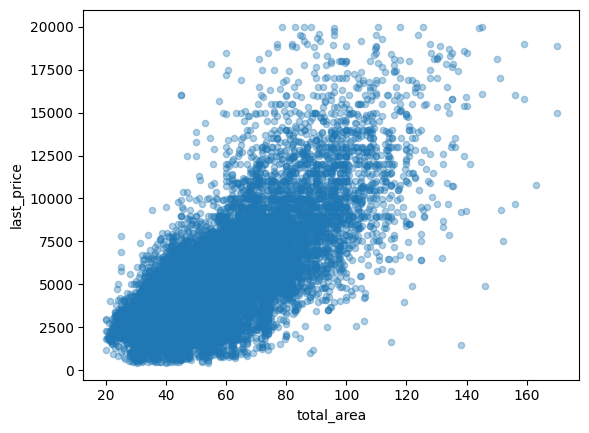

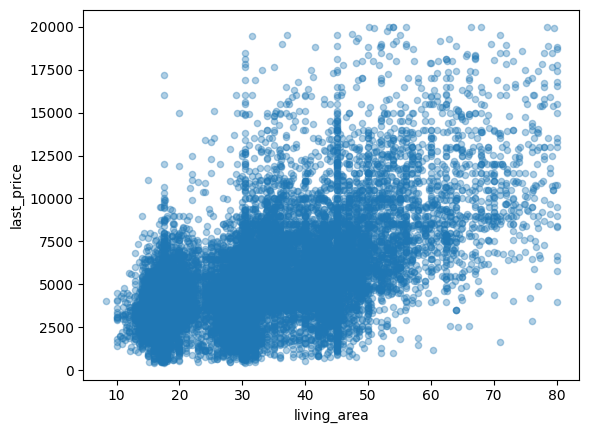

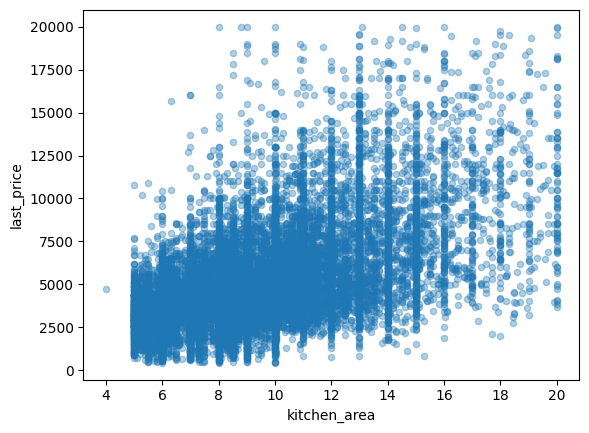

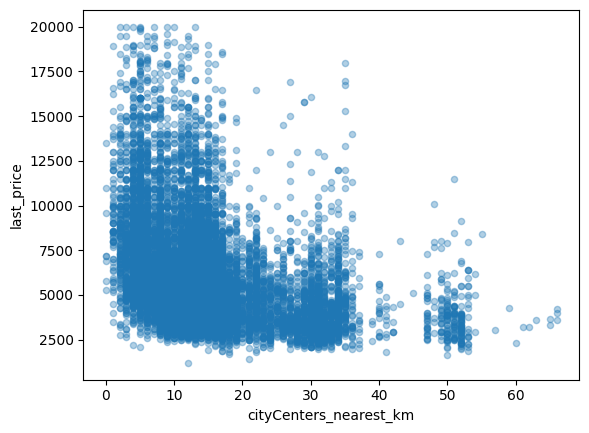

In [158]:
for col in ['total_area', 'living_area', 'kitchen_area', 'cityCenters_nearest_km']:
    data.plot(x=col, y='last_price', kind='scatter', alpha=0.35)
    plt.show()

Заметим, что достаточно сильную корреляцию цена имеет с общей площадью, меньшую корреляцию - с жилой площадью и площадью кухни. С ценой также коррелирует количество комнат. Самую высокую отрицательную корреляцию цена имеет с расстоянием до цента - т.е. чем дальше квартира от центра, тем меньше она будет стоить.

Изучим, как этаж влияет на цену квартиры.

In [159]:
floor_type_price = data.groupby('floor_type')['last_price'].mean().sort_values()
floor_type_price

floor_type
первый       4168.343607
последний    4672.225612
другой       5323.594632
Name: last_price, dtype: float64

Выведем график, показывающий зависимость категории этажа и цены

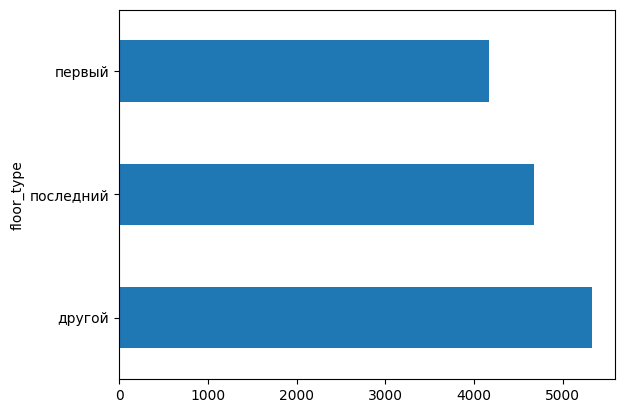

In [160]:
floor_type_price.sort_values(ascending=False).plot.barh()
None

Дешевле всего в среднем стоят квартиры на первом этаже (на 20% дешевле квартир на "другом" этаже), дороже всего - не на первом и не на последнем. <br>
Это обусловлено тем, что квартиры на первом этаже могут иметь ряд проблем - неприятные запахи из подвала, шум с улицы, пониженная безопасность. <br>
Квартиры на последнем этаже могут стоить дешевле, так как там возможны проблемы с теплоизоляцией и напором воды.

#### Влияние даты размещения

Изучим, как __день недели__ влияет на стоимость объекта.

In [161]:
week_day_price = data.groupby('publication_day_of_week')['last_price'].mean().sort_values(ascending=False)
week_day_price

publication_day_of_week
2    5173.036437
1    5141.906542
3    5121.218487
0    5085.102417
4    5016.868932
5    4977.709583
6    4964.089249
Name: last_price, dtype: float64

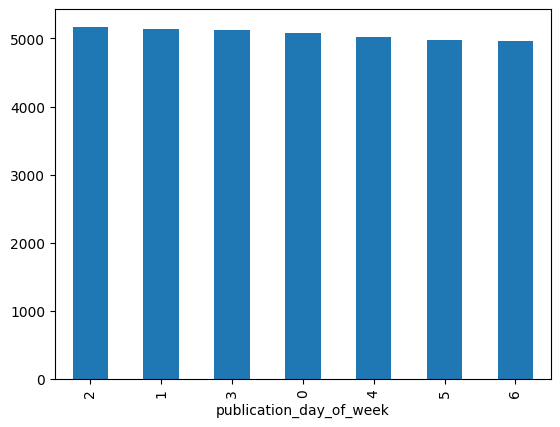

In [162]:
week_day_price.plot.bar()
None

Сложно найти логичное объяснение тому, что разница в средней цене между квартирами, выложенными в воскресенье и квартирами, выложенными в среду, составляет 208тыс. рублей. Возможно, это связано с тем, что, как мы видели выше, в будние дни выставляется больше квартир на продажу, пожтому и средняя цена оказывается выше. <br>
На графике однако видно, что средняя цена имеет минимальные изменения в зависимости от дня недели. 

Изучим влияние __месяца__ подачи объявления на цену.

In [163]:
month_price = data.groupby('publication_month')['last_price'].agg(['mean', 'count']).sort_values(by='mean')
month_price

,mean,count
publication_month,,
6,4879.541505,1542
5,4998.520147,1092
1,5020.914463,1286
7,5041.971508,1439
2,5050.547578,2312
12,5056.382603,1414
3,5069.293042,2242
10,5094.440470,1873
8,5120.968140,1538


Дешевле всего стоят квартиры, выставленные в июне и мае, дороже всего - в апреле и сентябре.

Визуализируем это.

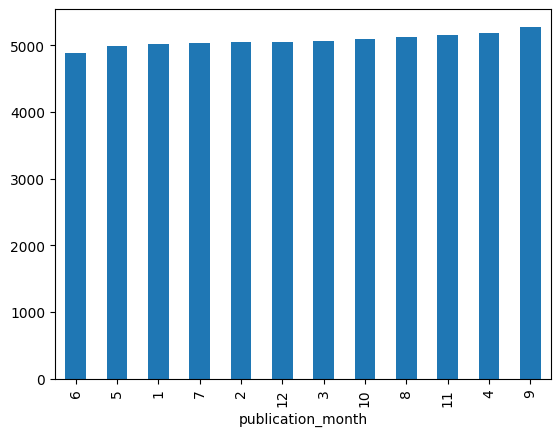

In [164]:
month_price['mean'].plot.bar()
None

На графике видно, что разница в цене незначительна.

Изучим, как __по годам__ менялась средняя стоимость квартир. 

In [165]:
year_price = data.groupby('publication_year')['last_price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
year_price

,mean,count
publication_year,,
2014,6893.870968,93
2015,5650.931330,932
2019,5368.019960,2505
2016,5042.047980,2376
2017,5004.042562,7166
2018,4995.203210,7539


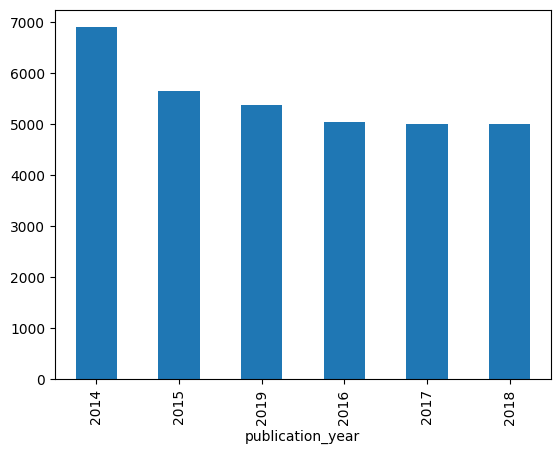

In [166]:
year_price['mean'].sort_values(ascending=False).plot.bar()
None

Дешевле всего квартиры стоили в 2018 году, при этом предложений было самое большое количество. В 2017 году был тот же порядок количества предложений, средняя цена была чуть выше. В 2019 году объявлений было всего 2504, но это связано с тем, что в датасете хранятся записи до мая 2019 года. В 2014 году средняя цена была самая высокая, но количество записей за этот год очень мало, к тому же за 2014 год есть только данные с 27 ноября, вероятно Яндекс Недвижимость только запустилась в это время. <br>
С 2014 по 2018 год средняя цена ежегодно падала. Нельзя сказать, продолжилась ли тенденция в 2019 году, так как, как уже было сказано, данные есть только за 5 месяцев 2019 года.

In [167]:
data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

In [168]:
data['first_day_exposition'].min()

Timestamp('2014-11-27 00:00:00')

#### Вывод 

Были изучены различные факторы, влияющие на стоимость квартиры. <br>
Наиболее влиятельным фактором оказалась площадь жилья, затем идет жилая площадь, площадь кухни, высота потолков, количество комнат. <br>
Почти не оказывают влияния на цену картографические параметры - расстояние до парка/пруда. <br>
Однако есть небольшая отрицательная корреляция с расстоянием до центра города - чем дальше от центра находится квартира, тем меньше стоимость. <br>
Зависимости между ценой и днем недели/месяцем не наблюдается. <br>
Также было обнаружено, что с 2014 по 2018 год средняя цена квартиры на портале Яндекс Недвижимости ежегодно падала. <br>

### Средняя цена кв.м. в самых популярных нас. пунктах

Для начала сохраним список 10 локаций с наибольшим количеством объявлений

In [169]:
most_popular_localities = data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)
most_popular_localities

locality_name
Санкт-Петербург      13190
поселок Мурино         520
поселок Шушары         420
Всеволожск             378
Колпино                315
Пушкин                 307
поселок Парголово      303
Гатчина                292
деревня Кудрово        275
Выборг                 221
Name: locality_name, dtype: int64

In [170]:
popular_locality_grouped = data.query('locality_name.isin(@most_popular_localities.index)').groupby('locality_name')['square_meter_price']
popular_locality_grouped.mean().sort_values(ascending=False)

locality_name
Санкт-Петербург      107.581533
Пушкин               101.446454
деревня Кудрово       92.963520
поселок Парголово     89.759129
поселок Мурино        85.222842
поселок Шушары        78.196202
Колпино               75.178316
Гатчина               68.833548
Всеволожск            66.955993
Выборг                58.242667
Name: square_meter_price, dtype: float64

Добавим визуализацию по ценам в 10 популярных населенных пунктах

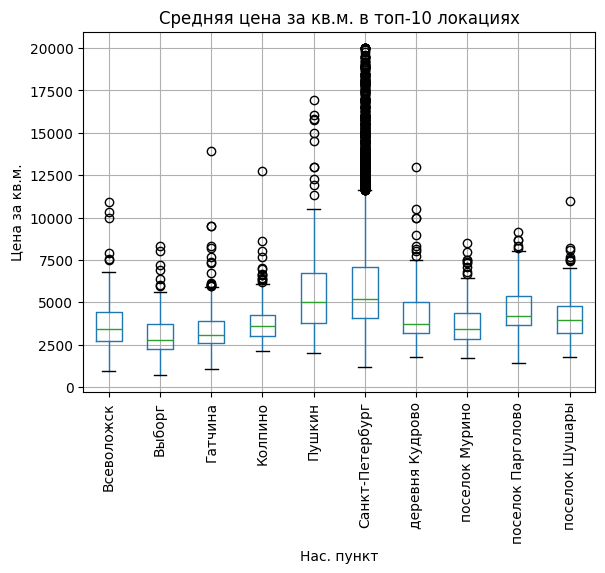

In [171]:
data.query('locality_name.isin(@most_popular_localities.index)').boxplot(column='last_price', by='locality_name')
plt.title('Средняя цена за кв.м. в топ-10 локациях')
plt.xlabel('Нас. пункт')
plt.ylabel('Цена за кв.м.')
plt.suptitle('')
plt.xticks(rotation=90) 

None

#### Вывод

Самая высокая цена квадратного метра - в Санкт-Петербурге (107000 руб), самая низкая - в Выборге (58000 рублей). Санкт-Петербург - это "северная столица", второй по численности населения город России, этим обусловлена самая высокая цена. Выборг же - город с населением чуть больше 76000 человек (на 2019 год), удаленный от Санкт-Петербурга на 137 км. 

### Изучение зависимости стоимости от расстояния до центра города

<Axes: xlabel='cityCenters_nearest_km'>

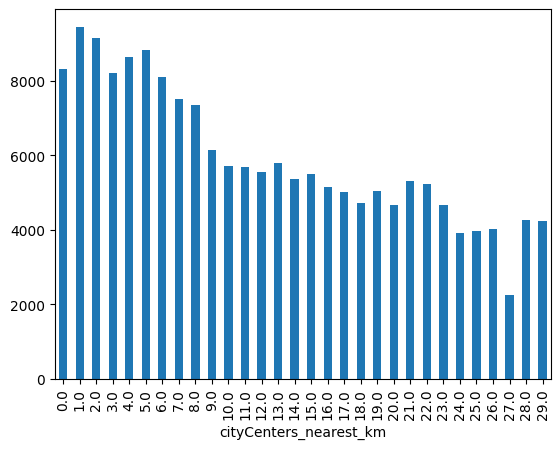

In [172]:
data.query('locality_name == "Санкт-Петербург"').groupby('cityCenters_nearest_km')['last_price'].mean().plot.bar()

#### Вывод

На диаграмме виден тренд снижения средней цены с увеличением отдаленности объекта от центра. Самые высокие цены - в центре города (удаленность до 6 км), их средняя цена - от 8 до 9 млн. <br>
Начиная с удаленности в 9 км цена значительно падает. (примерно на 1 млн) 

## Общий вывод

В ходе работы был проведен исследовательский анализ данных с сервиса Яндекс Недвижимость. <br>
Работа состояла из нескольких этапов.<br>

1. Изучение общей информации по данным
    - До обработки датасет хранил 23699 записей, 22 столбца. На данном этапе гистограммы были неинформативны из-за большого количества аномалий и выбросов в данных. 
2. Предобработка данных
    - Обработка пропусков
        - Больше половины параметров содержали пропуски, в каких-то (`is_apartment`, например) было пропущено 88% значений. 
        - Где было возможно (`is_apartment`, `balcony`, `ceiling_height`, `living_area`, `kitchen_area`, `days_exposition`), пропуски были заполнены
        - Записи с пропусками в `floors_total` и `locality_name` были удалены, количество таких записей было незначительно.
    - Обработка дубликатов
        - Дубликаты в колонке `locality_name` были устранены путем приведения к единому виду названия категории населенного пункта (нас. пункты типа "поселок" были объединены) 
    - Обработка аномалий
        - Почти во всех колонках встречались аномально маленькие или большие значения. 
        - Были удалены записи с аномальными значениями
        - В колонке `ceiling_height` аномальные значения были приведены к нормальному виду, где это было возможно. 
3. Добавление столбцов, необходимых для анализа
    - Для анализа был добавлен ряд столбцов
4. Изучение параметров объектов
    - Были изучены параметры площадей, расстояний, этажей, комнат, цены объекта, даты подачи объявления. 
    - Цена объекта имеет нормальное распределение с хвостом, уходящим вправо.
    - Наиболее часто встречаемые комнатности квартир - 1,2 и 3
    - Высота потолков редко бывает меньше 2.6 метров или больше 2.8
    - Чаще всего квартиры расположены на 1-5 этажах
    - Не на первом и не на последнем этаже расположено 73.6% квартир. На первом - 12.8%, на последнем - 13.7%
    - Самая частная высотность здания - 5 этажей, затем идет 9 этажей. Одноэтажные, очень высокие дома и дома с нестандартным количеством этажей встречаются реже всего
    - Расстояние до центра города также имеет распределение, похожее на нормальное, с небольшими пиками в хвосте справа, эти пики - крупные населенные пункты в ЛО
    - После предобработки данных в датасете остались объекты, расположенные от аэропорта в 6.45-85 км.
    - Картографические данные расстояния до парка имеет всего 30.5% записей, значение у большинства из них - от 100 до 800 метров.
    - В будние дни объявления выкладывались в более чем 2 раза чаще, чем в выходные
    - В феврале и марте было выложено больше всего объявлений, май и январь были наименее активными месяцами. 
    - Данные о кол-ве дней, которое объявление "провисело" на сайте, варьируются от 0 до 1580. 75% квартир было продано менее, чем за 7 месяцев. 50% - менее, чем за 2.5 месяца. 
5. Изучение факторов, влияющих на стоимость.
    - Больше всего на стоимость влияют параметры площади - общей, жилой, кухни, также комнатность и высота потолков. 
    - Наибольшую отрицательную корреляцию цена имеет с расстоянием до центра города. 
    - Квартиры на первом этаже стоят на 20% дешевле квартир между 1 и последним этажом. На последнем этаже квартиры также стоят дешевле на 12% в среднем дешевле
    - День недели и месяц подачи заявления не имеют прямой корреляции с ценой. Однако квартиры, выложенные в июне, стоят почти на 400 тысяч дешевле в среднем, чем квартиры, выложенные в сентябре, и на 300 тысяч дешевле выставленных в апреле. 
    - С 2014 по 2018 год цена на квартиры падала ежегодно. Данные за 2019 год неполные, вывод о дальнейшем падении цен сделать нельзя. 
6. Изучение средней цены в 10 самых популярных населенных пунктах
    - Самым популярным и дорогим населенным пунктом оказался Санкт-Петербург, следом за ним идет Пушкин. Самые низкие цены из 10 популярных нас. пунктов - в Выборге, средняя цена кв.м. меньше Санкт-Петегрбурга на 49тыс. рублей.
7. Изучение зависимости цены от удаленности от центра города. 
    - Самые дорогие квартиры располодежены в радиусе 5 километров от центра города. Практически для каждого следующего километра удаленности от центра цена падает.